In [1]:
from dataloader import PriceScenarioDataset
from utils import VaR, ES, score
from Discriminator import Discriminator
from Generator import Generator
from Tradining_Strategies import TradingStrategy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from preprocess.acf import *
# from preprocess.gaussianize import *

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# from model.torch_tcn import *

In [5]:
num_epochs = 100
# nz = 3
batch_size = 128
#seq_len = 127
# clip= 0.01
lr = 0.01

noise_size=100
pnl_size=100
market_size=5

if torch.cuda.is_available():  
  dev = "cuda" 
else:  
  dev = "cpu"

device = torch.device(dev) 

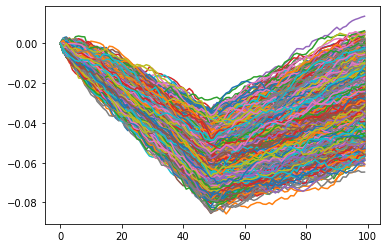

In [3]:
from scipy.stats import norm
def gen_toy_sample(x0,n):
    x0 = np.asarray(x0)
    N = norm.rvs(size=(n), scale=1e-3)
    u = np.concatenate((np.random.uniform(-1.5e-3,-8e-4,int(n/2)),np.random.uniform(4e-4,8e-4,int(n/2))))
    r = N+u
    out = np.empty(r.shape)
    np.cumsum(r, axis=-1, out=out)
    out += np.expand_dims(x0, axis=-1)
    return out
toy_sample_n = 10000
toy_sample = []
for i in range(toy_sample_n):
    toy_sample.append(gen_toy_sample(1,100))
toy_sample = np.array(toy_sample)

toy_sample_price_scenarios = np.empty(toy_sample.shape)
for i in range(toy_sample_n):
    toy_sample_price_scenarios[i,:] = np.log(toy_sample[i,:]/toy_sample[i,0])
    plt.plot(list(range(100)),toy_sample_price_scenarios[i,:])

In [4]:
toy_sample_tensor = torch.tensor(toy_sample_price_scenarios).cuda()
dataloader = torch.utils.data.DataLoader(toy_sample_tensor, batch_size=batch_size,drop_last=True,shuffle=True)

In [5]:
data_df = pd.read_csv("./data/Portfolios_Formed_on_ME_daily.csv", error_bad_lines=False)

C:\Users\ytc19\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
data_df["Lo 30"].apply(lambda x:x.split()[-1] if type(x)==str else x)[0]

'0.39'

In [7]:
# lo30_df=data_df["Lo 30"].apply(lambda x:x.split()[-1] if type(x)==str else x).apply(float)
# lo30_df=lo30_df.fillna(lo30_df.mean())
# lo30_data=lo30_df.to_numpy(dtype=np.float32).reshape(1,-1)
# lo30_data = torch.tensor(lo30_data,).cuda()
# dataset = PriceScenarioDataset(lo30_data,pnl_size, 1,True)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,drop_last=True,shuffle=True)
# for i in dataloader:
#     print(i[0].shape,i[-1].shape)
#     break
# len(dataset)

In [8]:
torch.ones_like(torch.tensor((2,1))).shape

torch.Size([2])

In [6]:
import torch.optim as optim
from tqdm import tqdm

generator = Generator(noise_size=noise_size,
                      pnl_size=pnl_size,market_size=batch_size
                     ).to(device)

train = True
# batch*pnl
trade_strategy = TradingStrategy("buy-hold",0,(0,0),(0,0))

if train:
    discriminator = Discriminator(pnl_size=pnl_size).to(device)
    disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    scheduler_disc = torch.optim.lr_scheduler.CosineAnnealingLR(disc_optimizer, T_max=1000, eta_min=0)
    gen_optimizer = optim.Adam(generator.parameters(), lr=lr)
    scheduler_gen = torch.optim.lr_scheduler.CosineAnnealingLR(gen_optimizer, T_max=1000, eta_min=0)

#     dataset = PriceScenarioDataset(lo30_data,pnl_size, 1,True)
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
#     dataset = Loader32(log_returns_preprocessed, 1)
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    c=0
    t = tqdm(range(1000))
    generator.train()
    discriminator.train()
    for epoch in t:
        for idx, data in enumerate(dataloader, 0):
#             print(data.shape)
            c+=1
#             print(idx,epoch)
            if True: #(idx<=10 and epoch ==0):
                discriminator.zero_grad()
                ps_real = data#.permute(0,2,1).squeeze(-1)
    #             score_real = data[-1].reshape(batch_size,-1)

                ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach()

                ts_real = trade_strategy.get_strategy_PnL(ps_real)#,torch.ones_like(ps_real))
                ts_fake = trade_strategy.get_strategy_PnL(ps_fake)#,torch.ones_like(ps_fake))

                fake_ve = discriminator(ts_fake)
                fake_v,fake_e = fake_ve[:,0],fake_ve[:,1]
                real_ve = discriminator(ts_real)
                real_v,real_e = real_ve[:,0],real_ve[:,1]
                if idx % 180 == 0:
                    print("disc:current fake and real ves: ",fake_ve[0],real_ve[0])


                disc_loss = torch.mean(score(fake_v,fake_e,ps_real,0.05)) - \
                                      torch.mean(score(real_v,real_e,ps_real,0.05))

    #             print('Discriminator Loss: %.8f' % (disc_loss.item()))

                disc_loss.backward()

                disc_optimizer.step()
                scheduler_disc.step()
            

#             discriminator.zero_grad()
#             real = data.to(device)
#             batch_size, seq_len = real.size(0), real.size(1)
#             noise = torch.randn(batch_size, nz, seq_len, device=device)
#             fake = generator(noise).detach()
#             disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
#             disc_loss.backward()
#             disc_optimizer.step()

#             for dp in discriminator.parameters():
#                 dp.data.clamp_(-clip, clip)
    
            if True: #not (idx<=10 and epoch ==0):# or idx % 2 == 0:
                for i in range(1):
                    generator.zero_grad()
                    discriminator.zero_grad()
                    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1)
                    ts_fake = trade_strategy.get_strategy_PnL(ps_fake)

                    fake_ve = discriminator(ts_fake)
                    fake_v,fake_e = fake_ve[:,0],fake_ve[:,1]

    #                 print(fake_ve[0],"asdsa")

                    gen_loss = -torch.mean(score(fake_v,fake_e,ps_real,0.05))

    #                 gen_loss = -torch.mean(discriminator(generator(noise)))
                    gen_loss.backward()
                    gen_optimizer.step()
                    scheduler_gen.step()
                if idx % 180 == 0:
                    print("gen:current fake ve: ",fake_ve[0])
        t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))
            
    # Save
    torch.save(generator, f"trained_generator_epoch_{epoch}.pth")

else:
    # Load
    generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')
    generator.eval()

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

disc:current fake and real ves:  tensor([ 0.0829, -0.0982], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 0.0846, -0.0991], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 0.1577, -0.1559], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 3.14169200 Generator Loss: 595.61940411:   0%|                    | 1/1000 [00:01<30:29,  1.83s/it]

disc:current fake and real ves:  tensor([ 18.1271, -17.8674], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 18.9314, -18.6785], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 20.4503, -20.1694], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1.12988684 Generator Loss: 0.65352007:   0%|                      | 2/1000 [00:02<20:22,  1.22s/it]

disc:current fake and real ves:  tensor([ 0.5188, -0.8799], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 0.3340, -0.8048], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 0.4201, -0.8280], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.02216678 Generator Loss: 2.09588882:   0%|                     | 3/1000 [00:03<17:13,  1.04s/it]

disc:current fake and real ves:  tensor([ 1.2564, -1.3569], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0126, -1.1222], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2753, -1.3732], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 6.72220810 Generator Loss: 15.35429159:   0%|                     | 4/1000 [00:04<15:50,  1.05it/s]

disc:current fake and real ves:  tensor([ 3.2357, -3.3038], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1351, -4.2863], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1037, -3.1687], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 0.55826656 Generator Loss: 3.45575328:   0%|                      | 5/1000 [00:05<14:54,  1.11it/s]

disc:current fake and real ves:  tensor([ 1.4303, -1.5302], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6236, -1.7178], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6574, -1.7331], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 0.05698934 Generator Loss: -0.07798907:   1%|▏                    | 6/1000 [00:05<14:33,  1.14it/s]

disc:current fake and real ves:  tensor([-1.2526,  0.2647], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0119,  0.1899], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1201,  0.2192], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 0.00804996 Generator Loss: -0.00912887:   1%|▏                    | 7/1000 [00:06<14:29,  1.14it/s]

disc:current fake and real ves:  tensor([-1.2703, -0.7968], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-0.8104, -0.5958], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.8014, -1.0971], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 0.10382370 Generator Loss: -0.00111053:   1%|▏                    | 8/1000 [00:07<14:33,  1.14it/s]

disc:current fake and real ves:  tensor([-1.5592, -1.3419], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-0.9021, -0.8629], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.1984, -1.0671], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.00183152 Generator Loss: -0.00022012:   1%|▏                   | 9/1000 [00:08<14:37,  1.13it/s]

disc:current fake and real ves:  tensor([-1.6741, -1.6757], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1088, -1.1593], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.2809, -1.3082], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 0.01047257 Generator Loss: -0.00011112:   1%|▏                   | 10/1000 [00:09<14:14,  1.16it/s]

disc:current fake and real ves:  tensor([-1.8251, -1.8000], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-0.9383, -1.0214], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5400, -1.5373], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 0.22263733 Generator Loss: -0.00017474:   1%|▏                   | 11/1000 [00:10<13:53,  1.19it/s]

disc:current fake and real ves:  tensor([-1.4359, -1.4466], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-0.9836, -1.0567], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5101, -1.5119], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.00190694 Generator Loss: -0.00019451:   1%|▏                  | 12/1000 [00:11<13:50,  1.19it/s]

disc:current fake and real ves:  tensor([-1.7394, -1.7386], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-0.9443, -1.0292], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4823, -1.4901], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 0.40799851 Generator Loss: -0.00016342:   1%|▎                   | 13/1000 [00:11<13:51,  1.19it/s]

disc:current fake and real ves:  tensor([-1.5416, -1.5446], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0791, -1.1387], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.7498, -1.7338], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 0.00269632 Generator Loss: -0.00012296:   1%|▎                   | 14/1000 [00:12<13:53,  1.18it/s]

disc:current fake and real ves:  tensor([-1.8392, -1.8335], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0602, -1.1205], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.7807, -1.7609], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.00223391 Generator Loss: -0.00011379:   2%|▎                  | 15/1000 [00:13<13:48,  1.19it/s]

disc:current fake and real ves:  tensor([-1.7955, -1.7919], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-0.8837, -0.9809], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4423, -1.4485], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.00173776 Generator Loss: -0.00017464:   2%|▎                  | 16/1000 [00:14<13:48,  1.19it/s]

disc:current fake and real ves:  tensor([-1.7276, -1.7218], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-0.7950, -0.9149], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.5867, -1.5872], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.00187089 Generator Loss: -0.00015960:   2%|▎                  | 17/1000 [00:15<13:43,  1.19it/s]

disc:current fake and real ves:  tensor([-1.7969, -1.7944], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-0.7775, -0.9055], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3291, -1.3540], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.00214070 Generator Loss: -0.00009881:   2%|▎                  | 18/1000 [00:16<13:33,  1.21it/s]

disc:current fake and real ves:  tensor([-1.7168, -1.6985], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-0.8626, -0.9716], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.3626, -1.3778], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 0.21228229 Generator Loss: -0.00025371:   2%|▍                   | 19/1000 [00:16<13:39,  1.20it/s]

disc:current fake and real ves:  tensor([-1.6883, -1.6842], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-0.8990, -1.0128], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.8992, -1.8885], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.00223068 Generator Loss: -0.00029234:   2%|▍                  | 20/1000 [00:17<13:29,  1.21it/s]

disc:current fake and real ves:  tensor([-1.4372, -1.4696], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3308, -1.3686], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.0262, -1.9915], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 0.02097764 Generator Loss: -0.00042990:   2%|▍                   | 21/1000 [00:18<13:18,  1.23it/s]

disc:current fake and real ves:  tensor([-1.6850, -1.6971], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1356, -1.2289], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.4716, -1.5106], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.00282709 Generator Loss: -0.00061045:   2%|▍                  | 22/1000 [00:19<13:14,  1.23it/s]

disc:current fake and real ves:  tensor([-1.7383, -1.7498], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.0478, -1.1755], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.8932, -1.8855], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.00354687 Generator Loss: -0.00071141:   2%|▍                  | 23/1000 [00:20<13:04,  1.25it/s]

disc:current fake and real ves:  tensor([-1.8412, -1.8512], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.3019, -1.3992], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.6083, -1.6540], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.00444427 Generator Loss: -0.00112550:   2%|▍                  | 24/1000 [00:20<13:02,  1.25it/s]

disc:current fake and real ves:  tensor([-1.6249, -1.6909], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4826, -1.5785], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.7601, -1.7964], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.00489078 Generator Loss: -0.00166402:   2%|▍                  | 25/1000 [00:21<13:09,  1.24it/s]

disc:current fake and real ves:  tensor([-1.5620, -1.6665], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4511, -1.5795], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3010, -2.2489], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.00632089 Generator Loss: -0.00165367:   3%|▍                  | 26/1000 [00:22<13:05,  1.24it/s]

disc:current fake and real ves:  tensor([-2.3930, -2.3535], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.1592, -1.4001], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.4042, -2.3496], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.00760460 Generator Loss: -0.00231496:   3%|▌                  | 27/1000 [00:23<13:04,  1.24it/s]

disc:current fake and real ves:  tensor([-1.7550, -1.8753], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-0.8447, -1.2116], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.7660, -1.8812], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.00847999 Generator Loss: -0.00248278:   3%|▌                  | 28/1000 [00:24<13:04,  1.24it/s]

disc:current fake and real ves:  tensor([-2.4116, -2.3869], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4534, -1.6969], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.1939, -2.2258], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.00910713 Generator Loss: -0.00276195:   3%|▌                  | 29/1000 [00:24<12:58,  1.25it/s]

disc:current fake and real ves:  tensor([-2.0918, -2.1723], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5854, -1.8184], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-1.9652, -2.0915], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.01048538 Generator Loss: -0.00350964:   3%|▌                  | 30/1000 [00:25<13:00,  1.24it/s]

disc:current fake and real ves:  tensor([-2.5941, -2.5636], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7164, -1.9467], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3269, -2.3667], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.01101586 Generator Loss: -0.00353982:   3%|▌                  | 31/1000 [00:26<13:17,  1.22it/s]

disc:current fake and real ves:  tensor([-2.6416, -2.6253], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7941, -2.0373], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.4887, -2.5061], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.01293389 Generator Loss: -0.00469581:   3%|▌                  | 32/1000 [00:27<13:32,  1.19it/s]

disc:current fake and real ves:  tensor([-2.0673, -2.2482], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5303, -1.8922], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.4673, -2.5109], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.01316678 Generator Loss: -0.00401265:   3%|▋                  | 33/1000 [00:28<13:35,  1.19it/s]

disc:current fake and real ves:  tensor([-2.5242, -2.5644], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9371, -2.1783], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2684, -2.3993], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.01403926 Generator Loss: -0.00575239:   3%|▋                  | 34/1000 [00:29<13:24,  1.20it/s]

disc:current fake and real ves:  tensor([-2.3292, -2.4690], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7174, -2.0708], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.2975, -3.1571], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.01502130 Generator Loss: -0.00483492:   4%|▋                  | 35/1000 [00:29<13:10,  1.22it/s]

disc:current fake and real ves:  tensor([-2.2396, -2.4146], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.9885, -2.2508], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3119, -2.4602], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.01430488 Generator Loss: -0.00543105:   4%|▋                  | 36/1000 [00:30<12:52,  1.25it/s]

disc:current fake and real ves:  tensor([-2.7055, -2.7296], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8025, -2.1481], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.1736, -2.3883], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.01516764 Generator Loss: -0.00627554:   4%|▋                  | 37/1000 [00:31<12:39,  1.27it/s]

disc:current fake and real ves:  tensor([-2.0250, -2.2976], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.4512, -1.9266], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.2818, -2.4609], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.01556531 Generator Loss: -0.00684157:   4%|▋                  | 38/1000 [00:32<12:41,  1.26it/s]

disc:current fake and real ves:  tensor([-2.7510, -2.7636], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5406, -1.9871], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.8090, -2.8056], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.01485001 Generator Loss: -0.00599139:   4%|▋                  | 39/1000 [00:32<12:21,  1.30it/s]

disc:current fake and real ves:  tensor([-2.4138, -2.5467], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5557, -1.9951], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.6427, -2.6942], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.01581106 Generator Loss: -0.00566994:   4%|▊                  | 40/1000 [00:33<12:17,  1.30it/s]

disc:current fake and real ves:  tensor([-1.7594, -2.1280], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5596, -1.9992], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.1718, -2.3922], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.01561900 Generator Loss: -0.00516900:   4%|▊                  | 41/1000 [00:34<12:15,  1.30it/s]

disc:current fake and real ves:  tensor([-2.6966, -2.7392], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7958, -2.1595], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.5523, -2.6463], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.01668497 Generator Loss: -0.00582707:   4%|▊                  | 42/1000 [00:35<12:38,  1.26it/s]

disc:current fake and real ves:  tensor([-2.1752, -2.4120], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5395, -2.0071], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.5812, -2.6721], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.01653237 Generator Loss: -0.00588141:   4%|▊                  | 43/1000 [00:36<12:48,  1.25it/s]

disc:current fake and real ves:  tensor([-3.1892, -3.0991], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.5768, -2.0541], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.0587, -3.0068], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.01780844 Generator Loss: -0.00749557:   4%|▊                  | 44/1000 [00:36<12:55,  1.23it/s]

disc:current fake and real ves:  tensor([-3.2528, -3.1724], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.2645, -2.5347], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.7280, -3.5185], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.01973236 Generator Loss: -0.00776025:   4%|▊                  | 45/1000 [00:37<13:25,  1.19it/s]

disc:current fake and real ves:  tensor([-3.5893, -3.4411], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.8595, -2.3361], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.3633, -2.6455], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.02282700 Generator Loss: -0.00856308:   5%|▊                  | 46/1000 [00:38<13:11,  1.21it/s]

disc:current fake and real ves:  tensor([-3.1732, -3.2091], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7421, -2.3454], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.5426, -2.8316], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.02389410 Generator Loss: -0.01017004:   5%|▉                  | 47/1000 [00:39<13:03,  1.22it/s]

disc:current fake and real ves:  tensor([-3.0111, -3.1865], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.9001, -3.1200], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-2.6033, -2.9472], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.02646158 Generator Loss: -0.01469123:   5%|▉                  | 48/1000 [00:40<12:46,  1.24it/s]

disc:current fake and real ves:  tensor([-4.0632, -3.9643], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-2.6305, -3.1205], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.2775, -3.4876], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.02748465 Generator Loss: -0.01928755:   5%|▉                  | 49/1000 [00:41<12:41,  1.25it/s]

disc:current fake and real ves:  tensor([-4.1455, -4.1418], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.7451, -2.7713], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-3.5816, -3.8137], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -0.04420499 Generator Loss: -0.15117467:   5%|▉                  | 50/1000 [00:41<12:35,  1.26it/s]

disc:current fake and real ves:  tensor([-30.2766, -29.1962], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-3.4176, -5.0808], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([-19.3993, -19.1251], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -357203333.23251146 Generator Loss: 867846042.62300694:   5%|▏   | 51/1000 [00:42<12:20,  1.28it/s]

disc:current fake and real ves:  tensor([ 12262.9990, -12048.2988], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 331.1689, -325.7163], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 16886.5996, -16626.4141], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -307046877218932.31250000 Generator Loss: 399094849972403.18750000:   5%| | 52/1000 [00:43<12:14,  

disc:current fake and real ves:  tensor([ 7642855.5000, -7638040.5000], device='cuda:0',
       grad_fn=<SelectBackward0>) tensor([ 933162., -932575.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 43987268., -43959760.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6582164551971912.00000000 Generator Loss: 1734910900314594.50000000:   5%| | 53/1000 [00:44<11:56,

disc:current fake and real ves:  tensor([ 34535016., -34523540.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4680035.5000, -4678568.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 29209554., -29201354.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -48344170408807576.00000000 Generator Loss: 19491961367531812.00000000:   5%| | 54/1000 [00:44<11:4

disc:current fake and real ves:  tensor([ 89693104., -89676592.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 13417651., -13415156.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 95892416., -95874992.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6792502733413087232.00000000 Generator Loss: 6665999372159847424.00000000:   6%| | 55/1000 [00:45<

disc:current fake and real ves:  tensor([ 2.2064e+09, -2.2061e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 21705222., -21702190.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3312e+09, -2.3306e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1053000857375518592.00000000 Generator Loss: 139773549461020928.00000000:   6%| | 56/1000 [00:46<1

disc:current fake and real ves:  tensor([ 1.7972e+08, -1.7969e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 28052274., -28048172.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7219e+08, -1.7217e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -50629324942299136.00000000 Generator Loss: 6922438924894471168.00000000:   6%| | 57/1000 [00:46<11

disc:current fake and real ves:  tensor([ 1.8269e+08, -1.8268e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 25430710., -25429590.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7276e+08, -2.7274e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -43138130065849760.00000000 Generator Loss: 106455737906202112.00000000:   6%| | 58/1000 [00:47<11:

disc:current fake and real ves:  tensor([ 1.9274e+08, -1.9272e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 28032714., -28029778.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6244e+08, -1.6243e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -34432992554454848.00000000 Generator Loss: 31273021894675856.00000000:   6%| | 59/1000 [00:48<11:1

disc:current fake and real ves:  tensor([ 1.8949e+08, -1.8946e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 30092838., -30088170.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 96325496., -96312480.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -24443806604057352.00000000 Generator Loss: 29336002739585776.00000000:   6%| | 60/1000 [00:49<11:1

disc:current fake and real ves:  tensor([ 2.4137e+08, -2.4132e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 30808794., -30802122.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0312e+08, -1.0309e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -22982616411147996.00000000 Generator Loss: 28250649721979780.00000000:   6%| | 61/1000 [00:49<11:1

disc:current fake and real ves:  tensor([ 88431552., -88413064.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 29241614., -29235674.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5244e+08, -1.5241e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25808887590474500.00000000 Generator Loss: 23152460259153724.00000000:   6%| | 62/1000 [00:50<11:1

disc:current fake and real ves:  tensor([ 67920880., -67911136.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 32454428., -32449952.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2036e+08, -1.2034e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -24196171257626300.00000000 Generator Loss: 23700409228231292.00000000:   6%| | 63/1000 [00:51<11:1

disc:current fake and real ves:  tensor([ 1.3776e+08, -1.3774e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 30265254., -30260662.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 97150928., -97135720.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -24334888839672300.00000000 Generator Loss: 572151367342529856.00000000:   6%| | 64/1000 [00:51<11:

disc:current fake and real ves:  tensor([ 1.2248e+08, -1.2246e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 29834530., -29830006.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4564e+08, -1.4562e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -24334019005293496.00000000 Generator Loss: 22030561166191620.00000000:   6%| | 65/1000 [00:52<11:1

disc:current fake and real ves:  tensor([ 1.6583e+08, -1.6580e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 29049012., -29044224.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.3235e+08, -1.3233e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -28185762235151988.00000000 Generator Loss: 24232543434479796.00000000:   7%| | 66/1000 [00:53<11:0

disc:current fake and real ves:  tensor([ 1.0597e+08, -1.0595e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 30575110., -30570274.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2636e+08, -1.2634e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -24669833156292360.00000000 Generator Loss: 23715123518939452.00000000:   7%| | 67/1000 [00:54<11:0

disc:current fake and real ves:  tensor([ 1.1964e+08, -1.1962e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 29946288., -29941944.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.9068e+08, -3.9062e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -20792050361491184.00000000 Generator Loss: 30836979786834796.00000000:   7%| | 68/1000 [00:54<11:0

disc:current fake and real ves:  tensor([ 1.9228e+08, -1.9227e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 27369152., -27367596.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4725e+08, -1.4725e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -20617152644768800.00000000 Generator Loss: 22767751407334812.00000000:   7%| | 69/1000 [00:55<11:0

disc:current fake and real ves:  tensor([ 99710632., -99694504.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 26714152., -26710008.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2122e+08, -1.2120e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -16080010660759458.00000000 Generator Loss: 21220916327344308.00000000:   7%| | 70/1000 [00:56<11:0

disc:current fake and real ves:  tensor([ 1.2042e+08, -1.2039e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 29554644., -29547874.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.3870e+08, -1.3867e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -21393000119390008.00000000 Generator Loss: 16205054189110956.00000000:   7%| | 71/1000 [00:56<11:0

disc:current fake and real ves:  tensor([ 62676880., -62666820.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 29800444., -29795838.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0165e+08, -1.0163e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -13363777884659698.00000000 Generator Loss: 183756213338090592.00000000:   7%| | 72/1000 [00:57<11:

disc:current fake and real ves:  tensor([ 1.4780e+08, -1.4776e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 31025688., -31018768.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5133e+08, -1.5130e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10915176134687050.00000000 Generator Loss: 10222277899464904.00000000:   7%| | 73/1000 [00:58<11:0

disc:current fake and real ves:  tensor([ 76600064., -76591792.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 30947740., -30944558.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 76985688., -76977464.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11006791892001210.00000000 Generator Loss: 9688467187416392.00000000:   7%| | 74/1000 [00:59<11:01

disc:current fake and real ves:  tensor([ 61204376., -61190604.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 28970784., -28964382.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 60323720., -60310192.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8315782340115609.00000000 Generator Loss: 10447701622206008.00000000:   8%| | 75/1000 [00:59<10:58

disc:current fake and real ves:  tensor([ 97422320., -97408112.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 30958504., -30954048.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 53404436., -53395856.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8412791730148628.00000000 Generator Loss: 9022066533883894.00000000:   8%| | 76/1000 [01:00<10:57,

disc:current fake and real ves:  tensor([ 43883348., -43878076.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 30693424., -30689866.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 77555224., -77544072.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6397641844797592.00000000 Generator Loss: 7639584458374359.00000000:   8%| | 77/1000 [01:01<10:55,

disc:current fake and real ves:  tensor([ 47769452., -47759688.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 35402692., -35395520.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 79987696., -79970344.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5453190823008590.00000000 Generator Loss: 7305575744122793.00000000:   8%| | 78/1000 [01:01<10:52,

disc:current fake and real ves:  tensor([ 42376964., -42369976.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 29205968., -29201224.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 80036064., -80026968.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10026343148642820.00000000 Generator Loss: 10990746919021748.00000000:   8%| | 79/1000 [01:02<10:5

disc:current fake and real ves:  tensor([ 67465824., -67459032.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 32676516., -32673224.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1501e+08, -1.1499e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6257490706475466.00000000 Generator Loss: 7786494771490092.00000000:   8%| | 80/1000 [01:03<10:54,

disc:current fake and real ves:  tensor([ 42471068., -42463000.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 36541124., -36534244.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 58779592., -58768600.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5645131155514665.00000000 Generator Loss: 5487079555092090.00000000:   8%| | 81/1000 [01:04<10:56,

disc:current fake and real ves:  tensor([ 71141800., -71133544.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 35010836., -35006816.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 44299560., -44294452.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4115358334949418.50000000 Generator Loss: 6137982742481441.00000000:   8%| | 82/1000 [01:04<10:57,

disc:current fake and real ves:  tensor([ 49847012., -49843292.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 30063300., -30061074.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 43434188., -43430948.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3397850285527878.00000000 Generator Loss: 5421456462547835.00000000:   8%| | 83/1000 [01:05<10:57,

disc:current fake and real ves:  tensor([ 42522368., -42515820.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 36573392., -36567804.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 49399488., -49392040.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3001125066989268.00000000 Generator Loss: 4750588604816592.00000000:   8%| | 84/1000 [01:06<10:55,

disc:current fake and real ves:  tensor([ 65427596., -65420252.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 31039466., -31035878.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 36045144., -36040576.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2840359904547300.00000000 Generator Loss: 4392497956884932.00000000:   8%| | 85/1000 [01:06<10:53,

disc:current fake and real ves:  tensor([ 38183856., -38177784.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 33103036., -33097714.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 43386300., -43379228.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2657364352456734.00000000 Generator Loss: 4293339217353190.50000000:   9%| | 86/1000 [01:07<10:52,

disc:current fake and real ves:  tensor([ 53337976., -53326548.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 35724200., -35716580.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 45890328., -45880584.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2649529217566167.50000000 Generator Loss: 14357253814485584.00000000:   9%| | 87/1000 [01:08<10:53

disc:current fake and real ves:  tensor([ 55632704., -55620880.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 31706012., -31699252.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 29149662., -29143396.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2570588161010748.50000000 Generator Loss: 4058091260896908.00000000:   9%| | 88/1000 [01:09<10:52,

disc:current fake and real ves:  tensor([ 44933012., -44922916.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 32579924., -32572560.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 30988834., -30981816.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2902591596299193.00000000 Generator Loss: 117698516094709808.00000000:   9%| | 89/1000 [01:09<10:4

disc:current fake and real ves:  tensor([ 49268044., -49257484.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 32970772., -32963726.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 37709500., -37701344.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3027103147840240.00000000 Generator Loss: 5686638198821868.00000000:   9%| | 90/1000 [01:10<10:48,

disc:current fake and real ves:  tensor([ 38271332., -38263068.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 33106542., -33099456.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 67383864., -67369632.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2986572706246423.50000000 Generator Loss: 3820612642828381.50000000:   9%| | 91/1000 [01:11<10:53,

disc:current fake and real ves:  tensor([ 44040180., -44030748.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 33482722., -33475552.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 40764620., -40755900.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3095213680990403.50000000 Generator Loss: 5223249530277096.00000000:   9%| | 92/1000 [01:11<10:56,

disc:current fake and real ves:  tensor([ 83946240., -83929464.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 34301048., -34294152.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 34454548., -34447536.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2063730114301781.50000000 Generator Loss: 3916961216322370.50000000:   9%| | 93/1000 [01:12<10:53,

disc:current fake and real ves:  tensor([ 57742912., -57730608.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 30981962., -30975326.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 36399136., -36391712.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3063823495477390.00000000 Generator Loss: 4430045372120761.50000000:   9%| | 94/1000 [01:13<10:49,

disc:current fake and real ves:  tensor([ 47289496., -47281712.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 32865604., -32860260.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 48364452., -48356588.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6805696670924520.00000000 Generator Loss: 4297718340459648.00000000:  10%| | 95/1000 [01:14<10:46,

disc:current fake and real ves:  tensor([ 52479244., -52470116.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 33294976., -33289100.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 41487372., -41480060.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5439250202912308.00000000 Generator Loss: 3419618886951617.50000000:  10%| | 96/1000 [01:14<10:43,

disc:current fake and real ves:  tensor([ 34756732., -34751556.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 30806640., -30802048.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 76066864., -76055592.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2327006963168957.50000000 Generator Loss: 3967478775040168.00000000:  10%| | 97/1000 [01:15<10:41,

disc:current fake and real ves:  tensor([ 36468176., -36463424.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 31496116., -31492100.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 31099922., -31095912.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2333949385773590.00000000 Generator Loss: 3796445601629574.50000000:  10%| | 98/1000 [01:16<10:43,

disc:current fake and real ves:  tensor([ 44330016., -44326496.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 31364760., -31362436.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 41063440., -41060524.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1970943267313384.25000000 Generator Loss: 3969735989222667.50000000:  10%| | 99/1000 [01:16<10:40,

disc:current fake and real ves:  tensor([ 38288784., -38284772.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 33573304., -33569832.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 59224876., -59218744.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2215138862013307.00000000 Generator Loss: 4760842693728991.00000000:  10%| | 100/1000 [01:17<10:40

disc:current fake and real ves:  tensor([ 40904848., -40896076.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 32503074., -32496110.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 50534332., -50524284.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6892040915787864.00000000 Generator Loss: 8336355824414328.00000000:  10%| | 101/1000 [01:18<10:39

disc:current fake and real ves:  tensor([ 96987160., -96971584.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 35069220., -35063544.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 71262472., -71251896.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -29096934351563868.00000000 Generator Loss: 28934827300715140.00000000:  10%| | 102/1000 [01:19<10:

disc:current fake and real ves:  tensor([ 1.2936e+08, -1.2934e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 36113912., -36108412.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4743e+08, -1.4742e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -17006313644236330.00000000 Generator Loss: 19523978993749368.00000000:  10%| | 103/1000 [01:19<10:

disc:current fake and real ves:  tensor([ 1.0103e+08, -1.0101e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 37315308., -37311032.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2780e+08, -1.2779e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15089583902716892.00000000 Generator Loss: 15696886327948796.00000000:  10%| | 104/1000 [01:20<10:

disc:current fake and real ves:  tensor([ 95949592., -95933512.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 36974372., -36968180.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0108e+08, -1.0106e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9900249159203230.00000000 Generator Loss: 12082367747292964.00000000:  10%| | 105/1000 [01:21<10:4

disc:current fake and real ves:  tensor([ 90998488., -90989416.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 36930096., -36926376.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 80862792., -80855768.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5357119056033936.00000000 Generator Loss: 11388513775484568.00000000:  11%| | 106/1000 [01:21<10:4

disc:current fake and real ves:  tensor([ 73014416., -73001360.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 41499160., -41491684.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 61798048., -61786940.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4553686232946833.00000000 Generator Loss: 6513923418142031.00000000:  11%| | 107/1000 [01:22<10:41

disc:current fake and real ves:  tensor([ 82060920., -82051712.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 35884064., -35879964.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 65065676., -65058368.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -13416151897074692.00000000 Generator Loss: 3451971468790273.50000000:  11%| | 108/1000 [01:23<10:4

disc:current fake and real ves:  tensor([ 43452284., -43444456.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 39436640., -39429532.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 51594472., -51585292.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1134365527415047.00000000 Generator Loss: 3045999972788057.50000000:  11%| | 109/1000 [01:24<10:40

disc:current fake and real ves:  tensor([ 41453608., -41445672.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 35114060., -35107336.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 50899596., -50889876.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1156304676608043.00000000 Generator Loss: 2595826875810658.00000000:  11%| | 110/1000 [01:24<10:35

disc:current fake and real ves:  tensor([ 50976740., -50970320.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 41978464., -41973132.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 34288544., -34284196.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -414249316772829.75000000 Generator Loss: 2833750931266534.50000000:  11%| | 111/1000 [01:25<10:33,

disc:current fake and real ves:  tensor([ 50533252., -50528836.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 42279444., -42275720.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 38168624., -38165180.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -491377860684006.00000000 Generator Loss: 2819647972227767.00000000:  11%| | 112/1000 [01:26<10:32,

disc:current fake and real ves:  tensor([ 35460284., -35456212.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 39438280., -39433780.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 33447026., -33443222.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -229651839565747.00000000 Generator Loss: 2760770498021078.00000000:  11%| | 113/1000 [01:26<10:30,

disc:current fake and real ves:  tensor([ 33012266., -33008510.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 42521988., -42517140.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 40907544., -40902940.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -579067736678396.50000000 Generator Loss: 2360614886844640.00000000:  11%| | 114/1000 [01:27<10:31,

disc:current fake and real ves:  tensor([ 33932672., -33928720.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 38614776., -38610428.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 36974200., -36970076.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -418688187369280.75000000 Generator Loss: 2716176895939238.00000000:  12%| | 115/1000 [01:28<10:29,

disc:current fake and real ves:  tensor([ 40303252., -40298656.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 38761408., -38757040.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 66477204., -66469768.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -622037573333859.75000000 Generator Loss: 2643522754228892.00000000:  12%| | 116/1000 [01:29<10:29,

disc:current fake and real ves:  tensor([ 46133476., -46128216.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 37035120., -37030952.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 35676820., -35672868.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2272818965597305.50000000 Generator Loss: 2802068255709496.50000000:  12%| | 117/1000 [01:29<10:27

disc:current fake and real ves:  tensor([ 38931148., -38926708.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 43750404., -43745472.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 48689452., -48683920.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -326721837436908.00000000 Generator Loss: 2698949814696757.00000000:  12%| | 118/1000 [01:30<10:29,

disc:current fake and real ves:  tensor([ 40589092., -40584556.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 38667072., -38662732.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 37549624., -37545344.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -286477531870023.25000000 Generator Loss: 19188418329099120.00000000:  12%| | 119/1000 [01:31<10:28

disc:current fake and real ves:  tensor([ 39705704., -39701768.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 39838492., -39834556.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 49028876., -49024176.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -358820111580688.75000000 Generator Loss: 2916021880692821.00000000:  12%| | 120/1000 [01:31<10:26,

disc:current fake and real ves:  tensor([ 39978288., -39974880.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 38615156., -38611868.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 36676780., -36673528.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -715509516855737088.00000000 Generator Loss: 3068773332842406.00000000:  12%| | 121/1000 [01:32<10:

disc:current fake and real ves:  tensor([ 38695216., -38688220.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 41058464., -41051048.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 35334456., -35329784.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10616523309193546.00000000 Generator Loss: 13283490279719466.00000000:  12%| | 122/1000 [01:33<10:

disc:current fake and real ves:  tensor([ 1.0153e+08, -1.0151e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 39068768., -39063344.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 72269736., -72259704.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -27411330281017440.00000000 Generator Loss: 29642106088681668.00000000:  12%| | 123/1000 [01:34<10:

disc:current fake and real ves:  tensor([ 1.2391e+08, -1.2389e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 39753472., -39748468.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8844e+08, -1.8842e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -46688184127350432.00000000 Generator Loss: 48503199412859392.00000000:  12%| | 124/1000 [01:34<10:

disc:current fake and real ves:  tensor([ 1.9192e+08, -1.9188e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 41976476., -41968452.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4897e+08, -1.4895e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -21457077865594660.00000000 Generator Loss: 22490004977783684.00000000:  12%|▏| 125/1000 [01:35<10:

disc:current fake and real ves:  tensor([ 1.1523e+08, -1.1521e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 46485724., -46478024.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1770e+08, -1.1768e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -54025481102962832.00000000 Generator Loss: 54163199916092624.00000000:  13%|▏| 126/1000 [01:36<10:

disc:current fake and real ves:  tensor([ 2.6921e+08, -2.6915e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 43811848., -43801896.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3300e+08, -2.3296e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -114445160726429360.00000000 Generator Loss: 23627319132686512.00000000:  13%|▏| 127/1000 [01:36<10

disc:current fake and real ves:  tensor([ 92225056., -92211784.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 48379076., -48372020.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6380e+08, -1.6378e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -22347600158875400.00000000 Generator Loss: 28947592161876096.00000000:  13%|▏| 128/1000 [01:37<10:

disc:current fake and real ves:  tensor([ 1.2775e+08, -1.2773e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 50715960., -50707272.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6683e+08, -1.6680e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -40672259321724640.00000000 Generator Loss: 44596326569791544.00000000:  13%|▏| 129/1000 [01:38<10:

disc:current fake and real ves:  tensor([ 1.7573e+08, -1.7571e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 55524732., -55515996.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7519e+08, -1.7516e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -27121961256530992.00000000 Generator Loss: 33373730518490456.00000000:  13%|▏| 130/1000 [01:39<10:

disc:current fake and real ves:  tensor([ 1.2971e+08, -1.2969e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 61938244., -61925592.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.0996e+08, -2.0993e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15703737155304604.00000000 Generator Loss: 18649911031120728.00000000:  13%|▏| 131/1000 [01:39<10:

disc:current fake and real ves:  tensor([ 1.2246e+08, -1.2245e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 56240244., -56237708.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 99580736., -99575232.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -17502515170823084.00000000 Generator Loss: 23404208990641460.00000000:  13%|▏| 132/1000 [01:40<10:

disc:current fake and real ves:  tensor([ 1.3098e+08, -1.3095e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 58896676., -58882712.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1350e+08, -1.1347e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11436031053336334.00000000 Generator Loss: 16892281399315498.00000000:  13%|▏| 133/1000 [01:41<10:

disc:current fake and real ves:  tensor([ 1.3599e+08, -1.3597e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 60891048., -60885388.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.3472e+08, -1.3472e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7912354041574503.00000000 Generator Loss: 12195023534522456.00000000:  13%|▏| 134/1000 [01:41<10:2

disc:current fake and real ves:  tensor([ 87762320., -87756184.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 62349284., -62345024.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0839e+08, -1.0838e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2800959528856449.00000000 Generator Loss: 7968748104373471.00000000:  14%|▏| 135/1000 [01:42<10:35

disc:current fake and real ves:  tensor([ 1.2384e+08, -1.2383e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 64640480., -64636112.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 75629952., -75624840.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 139065879042828.00000000 Generator Loss: 5131132952393219.00000000:  14%|▏| 136/1000 [01:43<10:50, 

disc:current fake and real ves:  tensor([ 55824280., -55811208.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 63195816., -63180892.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 52733824., -52721440.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 277109130285238.00000000 Generator Loss: 4839164353205403.00000000:  14%|▏| 137/1000 [01:44<10:43, 

disc:current fake and real ves:  tensor([ 53375896., -53363948.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 62434216., -62420188.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 63158912., -63144812.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 731341440131502.00000000 Generator Loss: 5349157825725609.00000000:  14%|▏| 138/1000 [01:44<10:35, 

disc:current fake and real ves:  tensor([ 56417220., -56405972.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 60319092., -60307040.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 60288864., -60276924.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 435096735666305.00000000 Generator Loss: 5083269576790083.00000000:  14%|▏| 139/1000 [01:45<10:27, 

disc:current fake and real ves:  tensor([ 51848632., -51838340.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 62650276., -62637764.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 58863128., -58851364.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1000941756665988.00000000 Generator Loss: 5118532803661585.00000000:  14%|▏| 140/1000 [01:46<10:23,

disc:current fake and real ves:  tensor([ 55063160., -55052104.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 66335456., -66322192.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 55010476., -54999568.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 883391553549018.00000000 Generator Loss: 4813264246293430.00000000:  14%|▏| 141/1000 [01:47<10:21, 

disc:current fake and real ves:  tensor([ 55439660., -55428644.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 59356264., -59344388.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 55674672., -55663564.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 474123122126286.00000000 Generator Loss: 5147283547453695.00000000:  14%|▏| 142/1000 [01:47<10:20, 

disc:current fake and real ves:  tensor([ 56348280., -56337104.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 62366568., -62354112.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 60599252., -60587200.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 600885367395120.00000000 Generator Loss: 4890041280555579.00000000:  14%|▏| 143/1000 [01:48<10:18, 

disc:current fake and real ves:  tensor([ 57294172., -57282756.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 60171508., -60159484.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 53214740., -53204092.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 478633536554285.00000000 Generator Loss: 5347394056808047.00000000:  14%|▏| 144/1000 [01:49<10:19, 

disc:current fake and real ves:  tensor([ 55494380., -55483348.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 63594500., -63581788.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 56939700., -56928344.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 644367378162529.00000000 Generator Loss: 5038169394807008.00000000:  14%|▏| 145/1000 [01:50<10:17, 

disc:current fake and real ves:  tensor([ 82651608., -82636160.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 65967120., -65954772.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 53108260., -53098956.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 561382541314368.00000000 Generator Loss: 5234622954238467.00000000:  15%|▏| 146/1000 [01:50<10:16, 

disc:current fake and real ves:  tensor([ 54771276., -54763632.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 66030028., -66020760.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 56254540., -56246648.], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -17698697305162426.00000000 Generator Loss: 23760658551469732.00000000:  15%|▏| 147/1000 [01:51<10:

disc:current fake and real ves:  tensor([ 98468728., -98463184.], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 63749940., -63746316.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0173e+08, -1.0173e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -28419082803920728.00000000 Generator Loss: 33962290261142568.00000000:  15%|▏| 148/1000 [01:52<10:

disc:current fake and real ves:  tensor([ 1.7789e+08, -1.7787e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 64943648., -64936236.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4515e+08, -1.4512e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -49610504433913712.00000000 Generator Loss: 56048921818660312.00000000:  15%|▏| 149/1000 [01:52<10:

disc:current fake and real ves:  tensor([ 1.5967e+08, -1.5967e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 67708088., -67705200.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9544e+08, -1.9543e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -88504966018778208.00000000 Generator Loss: 93669133505217824.00000000:  15%|▏| 150/1000 [01:53<10:

disc:current fake and real ves:  tensor([ 2.5570e+08, -2.5566e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 75252104., -75241032.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.6545e+08, -2.6543e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -53711129991164224.00000000 Generator Loss: 438914578826260928.00000000:  15%|▏| 151/1000 [01:54<10

disc:current fake and real ves:  tensor([ 2.5293e+08, -2.5292e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 74912424., -74910216.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.1090e+08, -2.1088e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -63402525922436256.00000000 Generator Loss: 74077517731732336.00000000:  15%|▏| 152/1000 [01:55<10:

disc:current fake and real ves:  tensor([ 2.1713e+08, -2.1712e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 81971704., -81967488.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.8385e+08, -2.8383e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -67720711210923120.00000000 Generator Loss: 77064381146711184.00000000:  15%|▏| 153/1000 [01:55<10:

disc:current fake and real ves:  tensor([ 2.5998e+08, -2.5994e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 92191504., -92175920.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.9326e+08, -9.9313e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -244535424370918144.00000000 Generator Loss: 65148995875260672.00000000:  15%|▏| 154/1000 [01:56<10

disc:current fake and real ves:  tensor([ 2.1528e+08, -2.1526e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 93765184., -93754656.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.0372e+08, -2.0369e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -57054602528865888.00000000 Generator Loss: 69772619034478760.00000000:  16%|▏| 155/1000 [01:57<10:

disc:current fake and real ves:  tensor([ 2.0161e+08, -2.0159e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 99758304., -99746288.], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8938e+08, -1.8937e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -68373431907392904.00000000 Generator Loss: 89619242692539664.00000000:  16%|▏| 156/1000 [01:57<10:

disc:current fake and real ves:  tensor([ 2.3969e+08, -2.3967e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1292e+08, -1.1291e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3935e+08, -2.3931e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -68598303064646304.00000000 Generator Loss: 190446650864980640.00000000:  16%|▏| 157/1000 [01:58<10

disc:current fake and real ves:  tensor([ 2.5256e+08, -2.5251e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1673e+08, -1.1671e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7632e+08, -2.7630e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -50688189967444192.00000000 Generator Loss: 74745089049948640.00000000:  16%|▏| 158/1000 [01:59<10:

disc:current fake and real ves:  tensor([ 2.1955e+08, -2.1954e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2082e+08, -1.2081e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3654e+08, -2.3653e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -38667627373762256.00000000 Generator Loss: 59224492471884088.00000000:  16%|▏| 159/1000 [02:00<10:

disc:current fake and real ves:  tensor([ 2.1147e+08, -2.1145e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2659e+08, -1.2658e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.0286e+08, -2.0284e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -21783899171556416.00000000 Generator Loss: 42522304681255888.00000000:  16%|▏| 160/1000 [02:00<10:

disc:current fake and real ves:  tensor([ 1.6659e+08, -1.6659e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1348e+08, -1.1348e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6764e+08, -1.6763e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15509946201486188.00000000 Generator Loss: 37348253170903616.00000000:  16%|▏| 161/1000 [02:01<09:

disc:current fake and real ves:  tensor([ 1.5274e+08, -1.5272e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2118e+08, -1.2117e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4522e+08, -1.4521e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 5825843841566522.00000000 Generator Loss: 16147971808464656.00000000:  16%|▏| 162/1000 [02:02<09:58

disc:current fake and real ves:  tensor([ 1.0809e+08, -1.0808e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2462e+08, -1.2462e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0651e+08, -1.0650e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -783238931734548.00000000 Generator Loss: 16144775243781650.00000000:  16%|▏| 163/1000 [02:02<09:55

disc:current fake and real ves:  tensor([ 1.0702e+08, -1.0701e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2702e+08, -1.2701e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0360e+08, -1.0359e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 5665752519623108.00000000 Generator Loss: 40523228437192616.00000000:  16%|▏| 164/1000 [02:03<09:54

disc:current fake and real ves:  tensor([ 1.0240e+08, -1.0240e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2482e+08, -1.2481e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0374e+08, -1.0374e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 5782521466666200.00000000 Generator Loss: 16052548962320994.00000000:  16%|▏| 165/1000 [02:04<09:54

disc:current fake and real ves:  tensor([ 1.0368e+08, -1.0367e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2360e+08, -1.2359e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0581e+08, -1.0580e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 5700066577995836.00000000 Generator Loss: 15714923034884220.00000000:  17%|▏| 166/1000 [02:04<09:54

disc:current fake and real ves:  tensor([ 1.0662e+08, -1.0661e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2556e+08, -1.2555e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0755e+08, -1.0754e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 5629511619776212.00000000 Generator Loss: 16339676539290568.00000000:  17%|▏| 167/1000 [02:05<09:52

disc:current fake and real ves:  tensor([ 1.0579e+08, -1.0578e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1331e+08, -1.1329e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1005e+08, -1.1003e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 5225567910027548.00000000 Generator Loss: 16083597548632514.00000000:  17%|▏| 168/1000 [02:06<09:52

disc:current fake and real ves:  tensor([ 1.0761e+08, -1.0760e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2256e+08, -1.2254e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0324e+08, -1.0323e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 5442334773413830.00000000 Generator Loss: 15738661069381368.00000000:  17%|▏| 169/1000 [02:07<09:51

disc:current fake and real ves:  tensor([ 1.0285e+08, -1.0284e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1696e+08, -1.1695e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0424e+08, -1.0424e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 5895031065530154.00000000 Generator Loss: 15840656875051558.00000000:  17%|▏| 170/1000 [02:07<09:51

disc:current fake and real ves:  tensor([ 1.0365e+08, -1.0364e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2372e+08, -1.2370e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0356e+08, -1.0354e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 5483699075400878.00000000 Generator Loss: 15968079045406306.00000000:  17%|▏| 171/1000 [02:08<09:52

disc:current fake and real ves:  tensor([ 1.0421e+08, -1.0421e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3047e+08, -1.3046e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0802e+08, -1.0802e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 3941660497222664.00000000 Generator Loss: 16795354034657042.00000000:  17%|▏| 172/1000 [02:09<09:50

disc:current fake and real ves:  tensor([ 1.0711e+08, -1.0709e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2011e+08, -1.2009e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1674e+08, -1.1672e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -77965034245004848.00000000 Generator Loss: 95720726417204192.00000000:  17%|▏| 173/1000 [02:09<09:

disc:current fake and real ves:  tensor([ 2.4923e+08, -2.4919e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2148e+08, -1.2146e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2240e+08, -2.2236e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -62003670318767200.00000000 Generator Loss: 84932653113593872.00000000:  17%|▏| 174/1000 [02:10<09:

disc:current fake and real ves:  tensor([ 2.6715e+08, -2.6712e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3270e+08, -1.3268e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4032e+08, -2.4032e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -91083180842716784.00000000 Generator Loss: 116487253039239616.00000000:  18%|▏| 175/1000 [02:11<09

disc:current fake and real ves:  tensor([ 2.7327e+08, -2.7322e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3397e+08, -1.3394e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1294e+08, -3.1291e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -129585371875162240.00000000 Generator Loss: 133176063324207776.00000000:  18%|▏| 176/1000 [02:12<0

disc:current fake and real ves:  tensor([ 3.4071e+08, -3.4067e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4688e+08, -1.4686e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.2968e+08, -3.2963e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -122645501594847136.00000000 Generator Loss: 171155321235973376.00000000:  18%|▏| 177/1000 [02:12<0

disc:current fake and real ves:  tensor([ 3.1169e+08, -3.1165e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6160e+08, -1.6158e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.0075e+08, -3.0071e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -204012159720944256.00000000 Generator Loss: 250898482084311200.00000000:  18%|▏| 178/1000 [02:13<0

disc:current fake and real ves:  tensor([ 4.6036e+08, -4.6033e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7494e+08, -1.7493e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.7337e+08, -4.7330e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -199088787274197824.00000000 Generator Loss: 229000388827395904.00000000:  18%|▏| 179/1000 [02:14<0

disc:current fake and real ves:  tensor([ 4.3261e+08, -4.3256e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8147e+08, -1.8145e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.8807e+08, -3.8802e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -245957729981123360.00000000 Generator Loss: 253797863317969280.00000000:  18%|▏| 180/1000 [02:14<0

disc:current fake and real ves:  tensor([ 3.9074e+08, -3.9067e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0852e+08, -2.0848e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.9717e+08, -3.9710e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -589351083716441728.00000000 Generator Loss: 805656293937585152.00000000:  18%|▏| 181/1000 [02:15<0

disc:current fake and real ves:  tensor([ 6.9038e+08, -6.9031e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4405e+08, -2.4402e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.1256e+08, -7.1249e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1060017282436545408.00000000 Generator Loss: 1221992322082303488.00000000:  18%|▏| 182/1000 [02:16

disc:current fake and real ves:  tensor([ 8.4339e+08, -8.4332e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.8715e+08, -2.8712e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.0766e+08, -7.0755e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -642765897461778432.00000000 Generator Loss: 881232005711270400.00000000:  18%|▏| 183/1000 [02:17<0

disc:current fake and real ves:  tensor([ 8.3411e+08, -8.3404e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1838e+08, -3.1835e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.4563e+08, -8.4555e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -407172502998888960.00000000 Generator Loss: 4117367319465705984.00000000:  18%|▏| 184/1000 [02:17<

disc:current fake and real ves:  tensor([ 6.4437e+08, -6.4429e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3280e+08, -3.3276e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.1257e+08, -6.1246e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -159111587774694336.00000000 Generator Loss: 311315062784915648.00000000:  18%|▏| 185/1000 [02:18<0

disc:current fake and real ves:  tensor([ 4.5859e+08, -4.5855e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4893e+08, -3.4890e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.7205e+08, -4.7200e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -86326745554783488.00000000 Generator Loss: 238867492913117280.00000000:  19%|▏| 186/1000 [02:19<09

disc:current fake and real ves:  tensor([ 4.5629e+08, -4.5623e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.5928e+08, -3.5923e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0623e+08, -4.0618e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -16992551373389856.00000000 Generator Loss: 167318480353063872.00000000:  19%|▏| 187/1000 [02:19<09

disc:current fake and real ves:  tensor([ 3.3210e+08, -3.3204e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3383e+08, -3.3378e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1613e+08, -3.1607e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 33191581587086656.00000000 Generator Loss: 129916956684134608.00000000:  19%|▏| 188/1000 [02:20<09:

disc:current fake and real ves:  tensor([ 2.8704e+08, -2.8699e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2350e+08, -3.2344e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.9291e+08, -2.9285e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 29675290434234784.00000000 Generator Loss: 132589468416770208.00000000:  19%|▏| 189/1000 [02:21<09:

disc:current fake and real ves:  tensor([ 2.8612e+08, -2.8607e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3742e+08, -3.3736e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.9159e+08, -2.9154e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 36542688893035792.00000000 Generator Loss: 124437652084466096.00000000:  19%|▏| 190/1000 [02:22<09:

disc:current fake and real ves:  tensor([ 3.2233e+08, -3.2228e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2990e+08, -3.2985e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.8974e+08, -2.8970e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 38342514508810400.00000000 Generator Loss: 121505421119899152.00000000:  19%|▏| 191/1000 [02:22<09:

disc:current fake and real ves:  tensor([ 2.8422e+08, -2.8419e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4749e+08, -3.4745e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.8883e+08, -2.8880e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 39530861236055872.00000000 Generator Loss: 122212697996892240.00000000:  19%|▏| 192/1000 [02:23<09:

disc:current fake and real ves:  tensor([ 2.8362e+08, -2.8359e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6494e+08, -3.6491e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.8459e+08, -2.8456e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 27443912885622400.00000000 Generator Loss: 124697737609356480.00000000:  19%|▏| 193/1000 [02:24<09:

disc:current fake and real ves:  tensor([ 2.8374e+08, -2.8371e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2624e+08, -3.2621e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.6355e+08, -4.6350e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 36683716706296800.00000000 Generator Loss: 124248195218073152.00000000:  19%|▏| 194/1000 [02:24<09:

disc:current fake and real ves:  tensor([ 2.9115e+08, -2.9112e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3842e+08, -3.3838e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.8769e+08, -2.8766e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 35143073073159984.00000000 Generator Loss: 122304902854178160.00000000:  20%|▏| 195/1000 [02:25<09:

disc:current fake and real ves:  tensor([ 2.8753e+08, -2.8750e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2142e+08, -3.2139e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.8507e+08, -2.8504e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -37918609445378784.00000000 Generator Loss: 125579609788903680.00000000:  20%|▏| 196/1000 [02:26<09

disc:current fake and real ves:  tensor([ 2.9123e+08, -2.9120e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3312e+08, -3.3308e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.8457e+08, -2.8454e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 35810319919182608.00000000 Generator Loss: 120117960147736080.00000000:  20%|▏| 197/1000 [02:27<09:

disc:current fake and real ves:  tensor([ 2.8611e+08, -2.8608e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3907e+08, -3.3905e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.9244e+08, -2.9242e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -102548923592431328.00000000 Generator Loss: 252201064470484384.00000000:  20%|▏| 198/1000 [02:27<1

disc:current fake and real ves:  tensor([ 4.8178e+08, -4.8174e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1155e+08, -3.1152e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.5506e+08, -4.5501e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -391798909419794688.00000000 Generator Loss: 563015152844774144.00000000:  20%|▏| 199/1000 [02:28<1

disc:current fake and real ves:  tensor([ 6.2679e+08, -6.2674e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6518e+08, -3.6516e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.4098e+08, -6.4094e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -499540405719655040.00000000 Generator Loss: 655476707892738944.00000000:  20%|▏| 200/1000 [02:29<0

disc:current fake and real ves:  tensor([ 6.2408e+08, -6.2404e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4823e+08, -3.4820e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.2828e+08, -7.2821e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -508425194484379328.00000000 Generator Loss: 697590987415815424.00000000:  20%|▏| 201/1000 [02:30<0

disc:current fake and real ves:  tensor([ 6.1694e+08, -6.1689e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.5745e+08, -3.5742e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.5793e+08, -6.5788e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -488548019438843904.00000000 Generator Loss: 681280323513576320.00000000:  20%|▏| 202/1000 [02:30<0

disc:current fake and real ves:  tensor([ 6.7085e+08, -6.7076e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9905e+08, -3.9900e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.6179e+08, -6.6174e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -675412245117615232.00000000 Generator Loss: 873707486782959744.00000000:  20%|▏| 203/1000 [02:31<0

disc:current fake and real ves:  tensor([ 8.9818e+08, -8.9809e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.8483e+08, -3.8480e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.0526e+08, -9.0512e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -329486946534907712.00000000 Generator Loss: 664636990271629952.00000000:  20%|▏| 204/1000 [02:32<0

disc:current fake and real ves:  tensor([ 6.7037e+08, -6.7033e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.7422e+08, -3.7420e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.0052e+08, -7.0044e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -480507345536945728.00000000 Generator Loss: 723832364734903808.00000000:  20%|▏| 205/1000 [02:32<0

disc:current fake and real ves:  tensor([ 7.2841e+08, -7.2834e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1866e+08, -4.1862e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.6322e+08, -7.6316e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -260160827388540128.00000000 Generator Loss: 1759845754171824640.00000000:  21%|▏| 206/1000 [02:33<

disc:current fake and real ves:  tensor([ 6.3351e+08, -6.3348e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1487e+08, -4.1484e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.2225e+08, -6.2218e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -594170854916992128.00000000 Generator Loss: 821686377737901952.00000000:  21%|▏| 207/1000 [02:34<0

disc:current fake and real ves:  tensor([ 7.6223e+08, -7.6220e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.2866e+08, -4.2864e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.5739e+08, -7.5732e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -373606139200798848.00000000 Generator Loss: 675792957236972160.00000000:  21%|▏| 208/1000 [02:35<0

disc:current fake and real ves:  tensor([ 6.0944e+08, -6.0940e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5769e+08, -4.5766e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.8192e+08, -6.8186e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -207893922304373312.00000000 Generator Loss: 505217608030136384.00000000:  21%|▏| 209/1000 [02:35<0

disc:current fake and real ves:  tensor([ 6.4485e+08, -6.4475e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5590e+08, -4.5583e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.4807e+08, -6.4801e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -444162552060336512.00000000 Generator Loss: 758416598677502976.00000000:  21%|▏| 210/1000 [02:36<0

disc:current fake and real ves:  tensor([ 6.3622e+08, -6.3618e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5141e+08, -4.5137e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.7122e+08, -6.7116e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -297029520644900352.00000000 Generator Loss: 612522840094728576.00000000:  21%|▏| 211/1000 [02:37<0

disc:current fake and real ves:  tensor([ 6.1154e+08, -6.1145e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8671e+08, -4.8664e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.1536e+08, -6.1529e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 43603692024288288.00000000 Generator Loss: 278811981542461216.00000000:  21%|▏| 212/1000 [02:38<09:

disc:current fake and real ves:  tensor([ 4.3727e+08, -4.3722e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5959e+08, -4.5954e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.5862e+08, -4.5857e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 81075186204019008.00000000 Generator Loss: 406820109927101568.00000000:  21%|▏| 213/1000 [02:38<09:

disc:current fake and real ves:  tensor([ 3.9856e+08, -3.9849e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8482e+08, -4.8475e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.1929e+08, -4.1923e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 86787961920470208.00000000 Generator Loss: 233953671859099392.00000000:  21%|▏| 214/1000 [02:39<09:

disc:current fake and real ves:  tensor([ 4.0245e+08, -4.0242e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8126e+08, -4.8122e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0451e+08, -4.0448e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 85958692928871200.00000000 Generator Loss: 234692123855055264.00000000:  22%|▏| 215/1000 [02:40<09:

disc:current fake and real ves:  tensor([ 4.0169e+08, -4.0166e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4304e+08, -4.4301e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0246e+08, -4.0243e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 83073688385362624.00000000 Generator Loss: 230543314483344096.00000000:  22%|▏| 216/1000 [02:41<09:

disc:current fake and real ves:  tensor([ 4.0188e+08, -4.0184e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8663e+08, -4.8658e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0216e+08, -4.0213e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 76867601145432416.00000000 Generator Loss: 251192103527018784.00000000:  22%|▏| 217/1000 [02:41<09:

disc:current fake and real ves:  tensor([ 4.0111e+08, -4.0107e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6342e+08, -4.6338e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0619e+08, -4.0615e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 81542999867124064.00000000 Generator Loss: 228271000608768096.00000000:  22%|▏| 218/1000 [02:42<09:

disc:current fake and real ves:  tensor([ 4.0196e+08, -4.0191e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6109e+08, -4.6104e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0263e+08, -4.0258e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -715914920749776640.00000000 Generator Loss: 232085262520604320.00000000:  22%|▏| 219/1000 [02:43<0

disc:current fake and real ves:  tensor([ 4.0391e+08, -4.0387e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.9749e+08, -4.9743e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0262e+08, -4.0258e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 77682776939269760.00000000 Generator Loss: 233294017612869344.00000000:  22%|▏| 220/1000 [02:43<09:

disc:current fake and real ves:  tensor([ 4.1238e+08, -4.1233e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8639e+08, -4.8634e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0164e+08, -4.0160e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 78478872589945888.00000000 Generator Loss: 229713896116999936.00000000:  22%|▏| 221/1000 [02:44<09:

disc:current fake and real ves:  tensor([ 4.0123e+08, -4.0118e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5706e+08, -4.5700e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0076e+08, -4.0071e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 82024100479025984.00000000 Generator Loss: 225570259072913632.00000000:  22%|▏| 222/1000 [02:45<09:

disc:current fake and real ves:  tensor([ 3.9775e+08, -3.9771e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7435e+08, -4.7431e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.9861e+08, -3.9858e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 85184280935771776.00000000 Generator Loss: 222776248499757792.00000000:  22%|▏| 223/1000 [02:46<09:

disc:current fake and real ves:  tensor([ 3.9587e+08, -3.9585e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7691e+08, -4.7689e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.9671e+08, -3.9670e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 73314384972605504.00000000 Generator Loss: 235487469027598272.00000000:  22%|▏| 224/1000 [02:46<09:

disc:current fake and real ves:  tensor([ 4.0675e+08, -4.0670e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7062e+08, -4.7056e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0704e+08, -4.0700e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -538859498354931392.00000000 Generator Loss: 857318175576676224.00000000:  22%|▏| 225/1000 [02:47<0

disc:current fake and real ves:  tensor([ 9.2147e+08, -9.2139e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5446e+08, -4.5442e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.7697e+08, -8.7686e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -802684427295177216.00000000 Generator Loss: 1152688330082345088.00000000:  23%|▏| 226/1000 [02:48<

disc:current fake and real ves:  tensor([ 8.7564e+08, -8.7556e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7086e+08, -4.7082e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.5359e+08, -8.5350e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -504101018857834624.00000000 Generator Loss: 890100038287698176.00000000:  23%|▏| 227/1000 [02:49<0

disc:current fake and real ves:  tensor([ 7.3985e+08, -7.3978e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.0682e+08, -5.0677e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.4595e+08, -7.4590e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -656352024150472192.00000000 Generator Loss: 1040765942966484480.00000000:  23%|▏| 228/1000 [02:49<

disc:current fake and real ves:  tensor([ 8.4839e+08, -8.4828e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.4296e+08, -5.4288e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 8.4614e+08, -8.4605e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1162526465684739584.00000000 Generator Loss: 1124050991518134784.00000000:  23%|▏| 229/1000 [02:50

disc:current fake and real ves:  tensor([ 2.0610e+09, -2.0609e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.8861e+08, -5.8858e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.8928e+08, -7.8922e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -658518441717724672.00000000 Generator Loss: 2333356020174973440.00000000:  23%|▏| 230/1000 [02:51<

disc:current fake and real ves:  tensor([ 9.2729e+08, -9.2722e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.1009e+08, -6.1005e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 9.7052e+08, -9.7044e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -671908538769490688.00000000 Generator Loss: 1235815139878293248.00000000:  23%|▏| 231/1000 [02:51<

disc:current fake and real ves:  tensor([ 9.9280e+08, -9.9264e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.0091e+08, -6.0081e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0019e+09, -1.0018e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1786589134159212544.00000000 Generator Loss: 2023898467100222464.00000000:  23%|▏| 232/1000 [02:52

disc:current fake and real ves:  tensor([ 1.0247e+09, -1.0246e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 6.7534e+08, -6.7528e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1126e+09, -1.1125e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1338628477558346752.00000000 Generator Loss: 2080346780937327360.00000000:  23%|▏| 233/1000 [02:53

disc:current fake and real ves:  tensor([ 1.3008e+09, -1.3007e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.5597e+08, -7.5591e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2698e+09, -1.2697e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -806452314627786496.00000000 Generator Loss: 3583957130280360448.00000000:  23%|▏| 234/1000 [02:54<

disc:current fake and real ves:  tensor([ 1.1352e+09, -1.1351e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.6942e+08, -7.6935e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1113e+09, -1.1111e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -812131979013353216.00000000 Generator Loss: 1840453792537072896.00000000:  24%|▏| 235/1000 [02:54<

disc:current fake and real ves:  tensor([ 1.0634e+09, -1.0633e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.1089e+08, -8.1081e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1340e+09, -1.1339e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -600517873947921280.00000000 Generator Loss: 1556733168097748736.00000000:  24%|▏| 236/1000 [02:55<

disc:current fake and real ves:  tensor([ 1.0173e+09, -1.0172e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.7858e+08, -7.7850e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0008e+09, -1.0008e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -270557789841014528.00000000 Generator Loss: 1230601338343520256.00000000:  24%|▏| 237/1000 [02:56<

disc:current fake and real ves:  tensor([ 9.7396e+08, -9.7388e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.8239e+08, -8.8232e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0045e+09, -1.0044e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 177418586487627648.00000000 Generator Loss: 828441529799906304.00000000:  24%|▏| 238/1000 [02:57<09

disc:current fake and real ves:  tensor([ 7.5307e+08, -7.5302e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.3493e+08, -8.3487e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.5630e+08, -7.5625e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 216910376316163712.00000000 Generator Loss: 785726082885032960.00000000:  24%|▏| 239/1000 [02:57<09

disc:current fake and real ves:  tensor([ 7.4764e+08, -7.4758e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.2562e+08, -8.2555e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.3148e+08, -7.3142e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 228674035983706240.00000000 Generator Loss: 769123131350095616.00000000:  24%|▏| 240/1000 [02:58<09

disc:current fake and real ves:  tensor([ 7.2621e+08, -7.2616e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.0222e+08, -9.0217e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.3041e+08, -7.3036e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 247528747900648320.00000000 Generator Loss: 757816242844531456.00000000:  24%|▏| 241/1000 [02:59<09

disc:current fake and real ves:  tensor([ 7.3176e+08, -7.3166e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.0081e+08, -8.0070e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.1508e+08, -7.1497e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 274651479118967936.00000000 Generator Loss: 719036070102136576.00000000:  24%|▏| 242/1000 [03:00<09

disc:current fake and real ves:  tensor([ 7.0311e+08, -7.0304e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.3539e+08, -8.3531e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.1735e+08, -7.1727e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 276383687240633088.00000000 Generator Loss: 718927468685879680.00000000:  24%|▏| 243/1000 [03:00<09

disc:current fake and real ves:  tensor([ 7.0522e+08, -7.0514e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.6222e+08, -8.6213e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.0497e+08, -7.0490e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 272077134405608320.00000000 Generator Loss: 714097167919694336.00000000:  24%|▏| 244/1000 [03:01<09

disc:current fake and real ves:  tensor([ 7.0333e+08, -7.0326e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.3536e+08, -8.3528e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.0517e+08, -7.0510e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 265049442981524224.00000000 Generator Loss: 714004152589427456.00000000:  24%|▏| 245/1000 [03:02<09

disc:current fake and real ves:  tensor([ 7.0411e+08, -7.0406e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.4642e+08, -8.4636e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.4275e+08, -7.4270e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 272193240464038016.00000000 Generator Loss: 714129491694583168.00000000:  25%|▏| 246/1000 [03:02<09

disc:current fake and real ves:  tensor([ 7.0314e+08, -7.0309e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.3666e+08, -8.3660e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.1227e+08, -7.1223e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 246265631135068800.00000000 Generator Loss: 729052094843897984.00000000:  25%|▏| 247/1000 [03:03<08

disc:current fake and real ves:  tensor([ 7.1916e+08, -7.1911e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.7121e+08, -7.7116e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.0510e+08, -7.0505e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 258340741723708800.00000000 Generator Loss: 723854291757101056.00000000:  25%|▏| 248/1000 [03:04<08

disc:current fake and real ves:  tensor([ 7.0678e+08, -7.0672e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.9739e+08, -7.9732e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.0862e+08, -7.0857e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 233362266829296128.00000000 Generator Loss: 719238725545095808.00000000:  25%|▏| 249/1000 [03:05<09

disc:current fake and real ves:  tensor([ 7.0652e+08, -7.0646e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 7.8059e+08, -7.8052e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.0556e+08, -7.0551e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 209029445903390848.00000000 Generator Loss: 1435519055139694336.00000000:  25%|▎| 250/1000 [03:05<0

disc:current fake and real ves:  tensor([ 7.4444e+08, -7.4437e+08], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.2643e+08, -8.2635e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.3778e+08, -7.3771e+08], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1172189407286328064.00000000 Generator Loss: 2212915252625538560.00000000:  25%|▎| 251/1000 [03:06

disc:current fake and real ves:  tensor([ 1.1691e+09, -1.1690e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 8.3789e+08, -8.3782e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.1939e+09, -1.1938e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1205581726607611392.00000000 Generator Loss: 2269443255769185024.00000000:  25%|▎| 252/1000 [03:07

disc:current fake and real ves:  tensor([ 1.3020e+09, -1.3018e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.1254e+08, -9.1240e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2896e+09, -1.2895e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1223674338749986560.00000000 Generator Loss: 2458654559562887168.00000000:  25%|▎| 253/1000 [03:08

disc:current fake and real ves:  tensor([ 1.2973e+09, -1.2972e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.2238e+08, -9.2232e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2736e+09, -1.2736e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1327669500351302912.00000000 Generator Loss: 2591124357374790144.00000000:  25%|▎| 254/1000 [03:08

disc:current fake and real ves:  tensor([ 1.5086e+09, -1.5084e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 9.5826e+08, -9.5815e+08], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5031e+09, -1.5030e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1332061351226347520.00000000 Generator Loss: 2859627816965121536.00000000:  26%|▎| 255/1000 [03:09

disc:current fake and real ves:  tensor([ 1.4061e+09, -1.4061e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0681e+09, -1.0680e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4339e+09, -1.4338e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1910332442105992448.00000000 Generator Loss: 3705939567397916160.00000000:  26%|▎| 256/1000 [03:10

disc:current fake and real ves:  tensor([ 1.6751e+09, -1.6749e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.0213e+09, -1.0211e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6438e+09, -1.6438e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2778732214776424960.00000000 Generator Loss: 6161989659273721856.00000000:  26%|▎| 257/1000 [03:10

disc:current fake and real ves:  tensor([ 1.7158e+09, -1.7156e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1946e+09, -1.1944e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6802e+09, -1.6801e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2111937737146553856.00000000 Generator Loss: 4258289239996191232.00000000:  26%|▎| 258/1000 [03:11

disc:current fake and real ves:  tensor([ 1.8149e+09, -1.8147e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.1966e+09, -1.1965e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6417e+09, -1.6416e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2204347935798422272.00000000 Generator Loss: 3964442223508209664.00000000:  26%|▎| 259/1000 [03:12

disc:current fake and real ves:  tensor([ 1.7917e+09, -1.7916e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2500e+09, -1.2499e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7464e+09, -1.7463e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1286238175266713344.00000000 Generator Loss: 3255381827334001152.00000000:  26%|▎| 260/1000 [03:13

disc:current fake and real ves:  tensor([ 1.5082e+09, -1.5081e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2789e+09, -1.2788e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5303e+09, -1.5302e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -975570535423677696.00000000 Generator Loss: 3302732594618463744.00000000:  26%|▎| 261/1000 [03:13<

disc:current fake and real ves:  tensor([ 1.4775e+09, -1.4773e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2596e+09, -1.2594e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4439e+09, -1.4437e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -48415810031346176.00000000 Generator Loss: 2396393143413553152.00000000:  26%|▎| 262/1000 [03:14<0

disc:current fake and real ves:  tensor([ 1.2931e+09, -1.2929e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3322e+09, -1.3321e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.2706e+09, -1.2705e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 696017722453598720.00000000 Generator Loss: 1706655838079772416.00000000:  26%|▎| 263/1000 [03:15<0

disc:current fake and real ves:  tensor([ 1.0945e+09, -1.0945e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3322e+09, -1.3321e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0959e+09, -1.0958e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 643790574320205056.00000000 Generator Loss: 1708700740597636864.00000000:  26%|▎| 264/1000 [03:15<0

disc:current fake and real ves:  tensor([ 1.0947e+09, -1.0946e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3570e+09, -1.3569e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0983e+09, -1.0982e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 560645459583364864.00000000 Generator Loss: 1698849400018329344.00000000:  26%|▎| 265/1000 [03:16<0

disc:current fake and real ves:  tensor([ 1.0934e+09, -1.0933e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2241e+09, -1.2240e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0944e+09, -1.0944e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 588865788853334528.00000000 Generator Loss: 1675735129524956160.00000000:  27%|▎| 266/1000 [03:17<0

disc:current fake and real ves:  tensor([ 1.0901e+09, -1.0900e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3125e+09, -1.3125e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0892e+09, -1.0892e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 615916250767072256.00000000 Generator Loss: 1659678756345208576.00000000:  27%|▎| 267/1000 [03:18<0

disc:current fake and real ves:  tensor([ 1.0843e+09, -1.0842e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2925e+09, -1.2924e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0856e+09, -1.0855e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 630454926726783232.00000000 Generator Loss: 1655580952420919296.00000000:  27%|▎| 268/1000 [03:18<0

disc:current fake and real ves:  tensor([ 1.0868e+09, -1.0867e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2163e+09, -1.2162e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0809e+09, -1.0808e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 617337607647440384.00000000 Generator Loss: 1656845353990453248.00000000:  27%|▎| 269/1000 [03:19<0

disc:current fake and real ves:  tensor([ 1.0787e+09, -1.0786e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2968e+09, -1.2967e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0808e+09, -1.0807e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 610599243886535168.00000000 Generator Loss: 1648570918344967936.00000000:  27%|▎| 270/1000 [03:20<0

disc:current fake and real ves:  tensor([ 1.0801e+09, -1.0800e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3372e+09, -1.3371e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0801e+09, -1.0800e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 570086123485408256.00000000 Generator Loss: 1648455376094439680.00000000:  27%|▎| 271/1000 [03:20<0

disc:current fake and real ves:  tensor([ 1.0838e+09, -1.0838e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3033e+09, -1.3032e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0781e+09, -1.0781e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 633879162537236992.00000000 Generator Loss: 1640782875636721664.00000000:  27%|▎| 272/1000 [03:21<0

disc:current fake and real ves:  tensor([ 1.0738e+09, -1.0737e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2817e+09, -1.2815e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0745e+09, -1.0744e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 617251946163908608.00000000 Generator Loss: 1630653217090056448.00000000:  27%|▎| 273/1000 [03:22<0

disc:current fake and real ves:  tensor([ 1.0739e+09, -1.0737e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2885e+09, -1.2884e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0740e+09, -1.0739e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 597083019766356992.00000000 Generator Loss: 1687187985828869376.00000000:  27%|▎| 274/1000 [03:23<0

disc:current fake and real ves:  tensor([ 1.1074e+09, -1.1073e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2345e+09, -1.2344e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0889e+09, -1.0888e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 645003970812729088.00000000 Generator Loss: 1642716992830835968.00000000:  28%|▎| 275/1000 [03:23<0

disc:current fake and real ves:  tensor([ 1.0784e+09, -1.0783e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2976e+09, -1.2976e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0768e+09, -1.0767e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 571442763406985984.00000000 Generator Loss: 1623234639787362816.00000000:  28%|▎| 276/1000 [03:24<0

disc:current fake and real ves:  tensor([ 1.0735e+09, -1.0735e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2623e+09, -1.2622e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.0737e+09, -1.0736e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1263914006923500544.00000000 Generator Loss: 3479575748209154048.00000000:  28%|▎| 277/1000 [03:25

disc:current fake and real ves:  tensor([ 1.7884e+09, -1.7883e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.2166e+09, -1.2166e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7374e+09, -1.7372e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1724323395438414848.00000000 Generator Loss: 4108565796788756992.00000000:  28%|▎| 278/1000 [03:25

disc:current fake and real ves:  tensor([ 1.6991e+09, -1.6989e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3202e+09, -1.3200e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6483e+09, -1.6482e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1373927065456865792.00000000 Generator Loss: 3879227696821423616.00000000:  28%|▎| 279/1000 [03:26

disc:current fake and real ves:  tensor([ 1.5314e+09, -1.5313e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4358e+09, -1.4357e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5970e+09, -1.5968e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1240136875087642112.00000000 Generator Loss: 3972146755664588800.00000000:  28%|▎| 280/1000 [03:27

disc:current fake and real ves:  tensor([ 1.6397e+09, -1.6395e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4512e+09, -1.4510e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7150e+09, -1.7149e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3209965220742951424.00000000 Generator Loss: 5701823532835416064.00000000:  28%|▎| 281/1000 [03:28

disc:current fake and real ves:  tensor([ 1.9211e+09, -1.9210e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.3948e+09, -1.3947e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9214e+09, -1.9213e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4510218807422152704.00000000 Generator Loss: 7389530905192818688.00000000:  28%|▎| 282/1000 [03:28

disc:current fake and real ves:  tensor([ 2.4330e+09, -2.4327e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.4825e+09, -1.4823e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4012e+09, -2.4010e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5498451774799340544.00000000 Generator Loss: 8544387371783263232.00000000:  28%|▎| 283/1000 [03:29

disc:current fake and real ves:  tensor([ 2.6462e+09, -2.6460e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7190e+09, -1.7189e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.6586e+09, -2.6584e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3393995275610149888.00000000 Generator Loss: 7188772502664215552.00000000:  28%|▎| 284/1000 [03:30

disc:current fake and real ves:  tensor([ 2.4363e+09, -2.4361e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.5748e+09, -1.5747e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.4135e+09, -2.4132e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3336985522998678528.00000000 Generator Loss: 7890728527548317696.00000000:  28%|▎| 285/1000 [03:30

disc:current fake and real ves:  tensor([ 2.3777e+09, -2.3776e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7194e+09, -1.7193e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.2514e+09, -2.2513e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 117399226740580864.00000000 Generator Loss: 4526647499694588416.00000000:  29%|▎| 286/1000 [03:31<0

disc:current fake and real ves:  tensor([ 1.7365e+09, -1.7364e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7159e+09, -1.7158e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7201e+09, -1.7200e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 530390311926574080.00000000 Generator Loss: 3651952001884917248.00000000:  29%|▎| 287/1000 [03:32<0

disc:current fake and real ves:  tensor([ 1.6579e+09, -1.6578e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7251e+09, -1.7250e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.6082e+09, -1.6080e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1019211331144463360.00000000 Generator Loss: 3023264575418433024.00000000:  29%|▎| 288/1000 [03:33<

disc:current fake and real ves:  tensor([ 1.4609e+09, -1.4608e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7351e+09, -1.7349e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4610e+09, -1.4609e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 989899347069638656.00000000 Generator Loss: 3339883855593617408.00000000:  29%|▎| 289/1000 [03:33<0

disc:current fake and real ves:  tensor([ 1.6545e+09, -1.6544e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6628e+09, -1.6627e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.5210e+09, -1.5209e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1214635909689511936.00000000 Generator Loss: 4604130457592531456.00000000:  29%|▎| 290/1000 [03:34<

disc:current fake and real ves:  tensor([ 1.4653e+09, -1.4652e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8281e+09, -1.8279e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4592e+09, -1.4591e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1199309518210169344.00000000 Generator Loss: 3645936910522997760.00000000:  29%|▎| 291/1000 [03:35<

disc:current fake and real ves:  tensor([ 1.5096e+09, -1.5095e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7601e+09, -1.7600e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4552e+09, -1.4551e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1128702428979125760.00000000 Generator Loss: 2992806816275648512.00000000:  29%|▎| 292/1000 [03:35<

disc:current fake and real ves:  tensor([ 1.4574e+09, -1.4573e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7384e+09, -1.7382e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4584e+09, -1.4583e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1218753394816512000.00000000 Generator Loss: 2976260576182313472.00000000:  29%|▎| 293/1000 [03:36<

disc:current fake and real ves:  tensor([ 1.4536e+09, -1.4535e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6958e+09, -1.6956e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4604e+09, -1.4603e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1037799997959403008.00000000 Generator Loss: 2982884186136159232.00000000:  29%|▎| 294/1000 [03:37<

disc:current fake and real ves:  tensor([ 1.4549e+09, -1.4548e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6687e+09, -1.6686e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4638e+09, -1.4638e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1153887690486393344.00000000 Generator Loss: 2993563711330555904.00000000:  30%|▎| 295/1000 [03:38<

disc:current fake and real ves:  tensor([ 1.4528e+09, -1.4527e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7324e+09, -1.7323e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4558e+09, -1.4557e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1108729153415941632.00000000 Generator Loss: 2996575338594966016.00000000:  30%|▎| 296/1000 [03:38<

disc:current fake and real ves:  tensor([ 1.4547e+09, -1.4546e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6222e+09, -1.6220e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4528e+09, -1.4527e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1107821510097078272.00000000 Generator Loss: 2993738419307141120.00000000:  30%|▎| 297/1000 [03:39<

disc:current fake and real ves:  tensor([ 1.4573e+09, -1.4571e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6282e+09, -1.6281e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4544e+09, -1.4543e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 981412579415579136.00000000 Generator Loss: 2996264630579031040.00000000:  30%|▎| 298/1000 [03:40<0

disc:current fake and real ves:  tensor([ 1.4545e+09, -1.4544e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7166e+09, -1.7164e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4589e+09, -1.4589e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1096081930927428096.00000000 Generator Loss: 2968494398039818240.00000000:  30%|▎| 299/1000 [03:40<

disc:current fake and real ves:  tensor([ 1.4468e+09, -1.4467e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7291e+09, -1.7290e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4508e+09, -1.4507e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1146433525304201728.00000000 Generator Loss: 2878015662909823488.00000000:  30%|▎| 300/1000 [03:41<

disc:current fake and real ves:  tensor([ 1.4270e+09, -1.4269e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6583e+09, -1.6582e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4254e+09, -1.4253e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1063502213816449536.00000000 Generator Loss: 2981417737315732992.00000000:  30%|▎| 301/1000 [03:42<

disc:current fake and real ves:  tensor([ 1.4591e+09, -1.4590e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7372e+09, -1.7370e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4566e+09, -1.4565e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1162271318999280640.00000000 Generator Loss: 2831570226430521344.00000000:  30%|▎| 302/1000 [03:43<

disc:current fake and real ves:  tensor([ 1.4196e+09, -1.4195e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7134e+09, -1.7133e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4201e+09, -1.4200e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 851012117728707072.00000000 Generator Loss: 2956437287601475584.00000000:  30%|▎| 303/1000 [03:43<0

disc:current fake and real ves:  tensor([ 1.4628e+09, -1.4627e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.6281e+09, -1.6281e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.4597e+09, -1.4596e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2652035847172591104.00000000 Generator Loss: 7136878999225404416.00000000:  30%|▎| 304/1000 [03:44

disc:current fake and real ves:  tensor([ 2.1343e+09, -2.1341e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8108e+09, -1.8107e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.1649e+09, -2.1647e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2374267623149049344.00000000 Generator Loss: 6426850356177899520.00000000:  30%|▎| 305/1000 [03:45

disc:current fake and real ves:  tensor([ 1.9562e+09, -1.9561e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7791e+09, -1.7790e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.0566e+09, -2.0564e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -347308668741597184.00000000 Generator Loss: 5092404796533614592.00000000:  31%|▎| 306/1000 [03:45<

disc:current fake and real ves:  tensor([ 1.9038e+09, -1.9036e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.9196e+09, -1.9194e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9504e+09, -1.9503e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3862154497865111552.00000000 Generator Loss: 5479588715378146304.00000000:  31%|▎| 307/1000 [03:46

disc:current fake and real ves:  tensor([ 1.9493e+09, -1.9492e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.7372e+09, -1.7371e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9854e+09, -1.9852e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -67561189063250042880.00000000 Generator Loss: 8498926670775085056.00000000:  31%|▎| 308/1000 [03:4

disc:current fake and real ves:  tensor([ 2.3067e+09, -2.3065e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 1.8283e+09, -1.8281e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.3330e+09, -2.3328e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3518549333899963392.00000000 Generator Loss: 11712931479602604032.00000000:  31%|▎| 309/1000 [03:4

disc:current fake and real ves:  tensor([ 2.6859e+09, -2.6857e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0091e+09, -2.0089e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.6764e+09, -2.6761e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -22469356499737096192.00000000 Generator Loss: 10540899040679245824.00000000:  31%|▎| 310/1000 [03:

disc:current fake and real ves:  tensor([ 2.5714e+09, -2.5711e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1104e+09, -2.1102e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.6057e+09, -2.6055e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3436456127613601792.00000000 Generator Loss: 9970847030702534656.00000000:  31%|▎| 311/1000 [03:49

disc:current fake and real ves:  tensor([ 2.6333e+09, -2.6331e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1183e+09, -2.1182e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.6068e+09, -2.6066e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4313111274442006528.00000000 Generator Loss: 10817731728577978368.00000000:  31%|▎| 312/1000 [03:5

disc:current fake and real ves:  tensor([ 2.7722e+09, -2.7720e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2755e+09, -2.2754e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.8132e+09, -2.8130e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 175615241654676480.00000000 Generator Loss: 5888849978507348992.00000000:  31%|▎| 313/1000 [03:50<0

disc:current fake and real ves:  tensor([ 1.9870e+09, -1.9869e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2303e+09, -2.2301e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.0064e+09, -2.0062e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1666204322851147776.00000000 Generator Loss: 5180673628737382400.00000000:  31%|▎| 314/1000 [03:51<

disc:current fake and real ves:  tensor([ 1.9013e+09, -1.9012e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2030e+09, -2.2029e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9710e+09, -1.9709e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1632506159763781632.00000000 Generator Loss: 4963470559692926976.00000000:  32%|▎| 315/1000 [03:52<

disc:current fake and real ves:  tensor([ 1.8738e+09, -1.8737e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3447e+09, -2.3445e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8743e+09, -1.8742e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1791486941047389184.00000000 Generator Loss: 4897248764458256384.00000000:  32%|▎| 316/1000 [03:53<

disc:current fake and real ves:  tensor([ 1.8524e+09, -1.8523e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.3112e+09, -2.3111e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8501e+09, -1.8500e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1827176303898779648.00000000 Generator Loss: 4789943653753013248.00000000:  32%|▎| 317/1000 [03:53<

disc:current fake and real ves:  tensor([ 1.8332e+09, -1.8331e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1508e+09, -2.1507e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8337e+09, -1.8336e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1761695091384425472.00000000 Generator Loss: 4747856953532126208.00000000:  32%|▎| 318/1000 [03:54<

disc:current fake and real ves:  tensor([ 1.8301e+09, -1.8300e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2038e+09, -2.2036e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9133e+09, -1.9131e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1881288204394174464.00000000 Generator Loss: 4748395932097435648.00000000:  32%|▎| 319/1000 [03:55<

disc:current fake and real ves:  tensor([ 1.8340e+09, -1.8339e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2240e+09, -2.2238e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.9767e+09, -1.9765e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1843947779174150144.00000000 Generator Loss: 4823874048942385152.00000000:  32%|▎| 320/1000 [03:55<

disc:current fake and real ves:  tensor([ 1.8348e+09, -1.8347e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1849e+09, -2.1847e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8341e+09, -1.8340e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1847944274225035264.00000000 Generator Loss: 4790240616534132736.00000000:  32%|▎| 321/1000 [03:56<

disc:current fake and real ves:  tensor([ 1.8377e+09, -1.8376e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1709e+09, -2.1707e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8326e+09, -1.8324e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1809622294742620160.00000000 Generator Loss: 4810968576634964992.00000000:  32%|▎| 322/1000 [03:57<

disc:current fake and real ves:  tensor([ 1.8426e+09, -1.8425e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1407e+09, -2.1406e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8396e+09, -1.8395e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1786934799779843072.00000000 Generator Loss: 4922313118667362304.00000000:  32%|▎| 323/1000 [03:58<

disc:current fake and real ves:  tensor([ 1.8446e+09, -1.8445e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4228e+09, -2.4227e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8423e+09, -1.8422e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1797440342402097152.00000000 Generator Loss: 4893199091723209728.00000000:  32%|▎| 324/1000 [03:58<

disc:current fake and real ves:  tensor([ 1.8832e+09, -1.8831e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1345e+09, -2.1343e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8635e+09, -1.8634e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1486173761392322560.00000000 Generator Loss: 4971612535807867904.00000000:  32%|▎| 325/1000 [03:59<

disc:current fake and real ves:  tensor([ 1.8864e+09, -1.8862e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2377e+09, -2.2375e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8542e+09, -1.8541e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1750310495107965952.00000000 Generator Loss: 4737104306078277632.00000000:  33%|▎| 326/1000 [04:00<

disc:current fake and real ves:  tensor([ 1.8239e+09, -1.8239e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.0614e+09, -2.0613e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8280e+09, -1.8279e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1699191291913226240.00000000 Generator Loss: 4769844609551259648.00000000:  33%|▎| 327/1000 [04:00<

disc:current fake and real ves:  tensor([ 2.0328e+09, -2.0326e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2269e+09, -2.2267e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.8192e+09, -1.8191e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: 1778404045961053184.00000000 Generator Loss: 5007039473864331264.00000000:  33%|▎| 328/1000 [04:01<

disc:current fake and real ves:  tensor([ 1.7937e+09, -1.7936e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1502e+09, -2.1501e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 1.7991e+09, -1.7990e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9354854884292108288.00000000 Generator Loss: 15922305350683768832.00000000:  33%|▎| 329/1000 [04:0

disc:current fake and real ves:  tensor([ 3.0515e+09, -3.0513e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1496e+09, -2.1495e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.2079e+09, -3.2078e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3957580413294453760.00000000 Generator Loss: 10327520993858404352.00000000:  33%|▎| 330/1000 [04:0

disc:current fake and real ves:  tensor([ 2.7597e+09, -2.7597e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.1623e+09, -2.1623e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7691e+09, -2.7690e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -2628685167392433152.00000000 Generator Loss: 10246242993013751808.00000000:  33%|▎| 331/1000 [04:0

disc:current fake and real ves:  tensor([ 2.6590e+09, -2.6591e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.2600e+09, -2.2601e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7124e+09, -2.7125e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4159406101595218944.00000000 Generator Loss: 11715080958325092352.00000000:  33%|▎| 332/1000 [04:0

disc:current fake and real ves:  tensor([ 2.8562e+09, -2.8561e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.4168e+09, -2.4167e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.8749e+09, -2.8746e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3613929348800282624.00000000 Generator Loss: 393984713522658869248.00000000:  33%|▎| 333/1000 [04:

disc:current fake and real ves:  tensor([ 4.1522e+09, -4.1517e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.5226e+09, -2.5223e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0066e+09, -4.0061e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -115593167036649373696.00000000 Generator Loss: 889299867235969925120.00000000:  33%|▎| 334/1000 [0

disc:current fake and real ves:  tensor([ 5.4863e+09, -5.4857e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.6655e+09, -2.6652e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.5479e+09, -6.5470e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -66485555436220973056.00000000 Generator Loss: 2155540484515530276864.00000000:  34%|▎| 335/1000 [0

disc:current fake and real ves:  tensor([ 5.3354e+09, -5.3348e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.7503e+09, -2.7500e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.0005e+09, -5.0004e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -38723530873735675904.00000000 Generator Loss: 25346782089165586432.00000000:  34%|▎| 336/1000 [04:

disc:current fake and real ves:  tensor([ 6.7649e+09, -6.7651e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.8362e+09, -2.8363e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.7581e+09, -6.7585e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -112364391962197540864.00000000 Generator Loss: 26653150853612908544.00000000:  34%|▎| 337/1000 [04

disc:current fake and real ves:  tensor([ 3.1893e+09, -3.1888e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.9576e+09, -2.9572e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.8851e+09, -5.8843e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -22339436881423818752.00000000 Generator Loss: 59344273206031810560.00000000:  34%|▎| 338/1000 [04:

disc:current fake and real ves:  tensor([ 4.6655e+09, -4.6650e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.9201e+09, -2.9197e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.1305e+09, -4.1300e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7856810467810289664.00000000 Generator Loss: 19999621368692051968.00000000:  34%|▎| 339/1000 [04:0

disc:current fake and real ves:  tensor([ 2.9804e+09, -2.9800e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0066e+09, -3.0063e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.0434e+09, -3.0431e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -87951516984989581312.00000000 Generator Loss: 19009104004004225024.00000000:  34%|▎| 340/1000 [04:

disc:current fake and real ves:  tensor([ 3.0894e+09, -3.0895e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0320e+09, -3.0321e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.0661e+09, -3.0663e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4289079814635778048.00000000 Generator Loss: 18659434847381413888.00000000:  34%|▎| 341/1000 [04:1

disc:current fake and real ves:  tensor([ 2.7171e+09, -2.7168e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0039e+09, -3.0036e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.7145e+09, -3.7139e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7077861473233281024.00000000 Generator Loss: 19384866243335479296.00000000:  34%|▎| 342/1000 [04:1

disc:current fake and real ves:  tensor([ 2.9000e+09, -2.8996e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0293e+09, -3.0289e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.8186e+09, -2.8182e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -61761790686978162688.00000000 Generator Loss: 35422064039362375680.00000000:  34%|▎| 343/1000 [04:

disc:current fake and real ves:  tensor([ 3.4894e+09, -3.4890e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1312e+09, -3.1308e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.5965e+09, -3.5962e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3142996292351211520.00000000 Generator Loss: 20624854037382864896.00000000:  34%|▎| 344/1000 [04:1

disc:current fake and real ves:  tensor([ 3.1438e+09, -3.1438e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0435e+09, -3.0434e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.7202e+09, -3.7201e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5566268155423692800.00000000 Generator Loss: 17334647906194030592.00000000:  34%|▎| 345/1000 [04:1

disc:current fake and real ves:  tensor([ 6.3043e+09, -6.3047e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0552e+09, -3.0554e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.2463e+09, -3.2465e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4765522506021914624.00000000 Generator Loss: 19351338933950857216.00000000:  35%|▎| 346/1000 [04:1

disc:current fake and real ves:  tensor([ 4.4298e+09, -4.4300e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.9589e+09, -2.9591e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.8553e+09, -2.8555e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -113203567756507447296.00000000 Generator Loss: 18362559348551620608.00000000:  35%|▎| 347/1000 [04

disc:current fake and real ves:  tensor([ 2.7283e+09, -2.7284e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1251e+09, -3.1253e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.8679e+09, -2.8681e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5310297920121589760.00000000 Generator Loss: 19473651143610384384.00000000:  35%|▎| 348/1000 [04:1

disc:current fake and real ves:  tensor([ 2.9146e+09, -2.9147e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4813e+09, -3.4814e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.6449e+09, -6.6451e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -3934954408604346368.00000000 Generator Loss: 18864025581959888896.00000000:  35%|▎| 349/1000 [04:1

disc:current fake and real ves:  tensor([ 3.9201e+09, -3.9197e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1651e+09, -3.1647e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.3231e+09, -3.3227e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4654232215892400128.00000000 Generator Loss: 19645069592412995584.00000000:  35%|▎| 350/1000 [04:1

disc:current fake and real ves:  tensor([ 3.5405e+09, -3.5401e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0178e+09, -3.0174e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.0026e+09, -3.0022e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -12885230012866181120.00000000 Generator Loss: 22280044663943512064.00000000:  35%|▎| 351/1000 [04:

disc:current fake and real ves:  tensor([ 3.3356e+09, -3.3357e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2088e+09, -3.2088e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3878e+09, -4.3880e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5008815115342399488.00000000 Generator Loss: 7162532621742133739520.00000000:  35%|▎| 352/1000 [04

disc:current fake and real ves:  tensor([ 2.7738e+09, -2.7737e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2918e+09, -3.2916e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 2.7922e+09, -2.7921e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -478764517796256219136.00000000 Generator Loss: 19029611339813093376.00000000:  35%|▎| 353/1000 [04

disc:current fake and real ves:  tensor([ 3.2519e+09, -3.2520e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0973e+09, -3.0973e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1724e+09, -3.1725e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7208926643771058176.00000000 Generator Loss: 20151352137209839616.00000000:  35%|▎| 354/1000 [04:2

disc:current fake and real ves:  tensor([ 6.4380e+09, -6.4371e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 2.9995e+09, -2.9991e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.2583e+09, -3.2578e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7134883581109903360.00000000 Generator Loss: 19476412306655780864.00000000:  36%|▎| 355/1000 [04:2

disc:current fake and real ves:  tensor([ 3.0397e+09, -3.0392e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1494e+09, -3.1489e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.3138e+09, -5.3132e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4645891894316283904.00000000 Generator Loss: 17241091228501022720.00000000:  36%|▎| 356/1000 [04:2

disc:current fake and real ves:  tensor([ 3.1438e+09, -3.1439e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2923e+09, -3.2925e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.1369e+09, -3.1371e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11420815704115226624.00000000 Generator Loss: 25201313289017671680.00000000:  36%|▎| 357/1000 [04:

disc:current fake and real ves:  tensor([ 5.0142e+09, -5.0144e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0669e+09, -3.0671e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.7321e+09, -3.7323e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -40426194321656938496.00000000 Generator Loss: 19313297190682775552.00000000:  36%|▎| 358/1000 [04:

disc:current fake and real ves:  tensor([ 3.2023e+09, -3.2024e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0660e+09, -3.0661e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.3043e+09, -3.3045e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -379175743298705752064.00000000 Generator Loss: 30001433247560695808.00000000:  36%|▎| 359/1000 [04

disc:current fake and real ves:  tensor([ 4.6519e+09, -4.6515e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3661e+09, -3.3658e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.4073e+09, -4.4072e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9974956916514584576.00000000 Generator Loss: 37349134343722950656.00000000:  36%|▎| 360/1000 [04:2

disc:current fake and real ves:  tensor([ 3.7707e+09, -3.7708e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3640e+09, -3.3641e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.5133e+09, -4.5132e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -432418097278608539648.00000000 Generator Loss: 22214463819551858688.00000000:  36%|▎| 361/1000 [04

disc:current fake and real ves:  tensor([ 6.4185e+09, -6.4188e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.0418e+09, -3.0420e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.7286e+09, -3.7287e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -21810027506624626688.00000000 Generator Loss: 22335991623008473088.00000000:  36%|▎| 362/1000 [04:

disc:current fake and real ves:  tensor([ 3.5856e+09, -3.5856e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3482e+09, -3.3482e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.3602e+09, -3.3602e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -12644539942073059328.00000000 Generator Loss: 29075579019608834048.00000000:  36%|▎| 363/1000 [04:

disc:current fake and real ves:  tensor([ 6.4470e+09, -6.4463e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3294e+09, -3.3290e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.9993e+09, -4.9987e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14627185129935710208.00000000 Generator Loss: 29145816027354955776.00000000:  36%|▎| 364/1000 [04:

disc:current fake and real ves:  tensor([ 4.1058e+09, -4.1051e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4907e+09, -3.4902e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0265e+09, -4.0260e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11585406259656108032.00000000 Generator Loss: 27144075854558486528.00000000:  36%|▎| 365/1000 [04:

disc:current fake and real ves:  tensor([ 4.0067e+09, -4.0069e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4576e+09, -3.4578e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.9104e+09, -4.9107e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -107359223560900378624.00000000 Generator Loss: 53846444669396303872.00000000:  37%|▎| 366/1000 [04

disc:current fake and real ves:  tensor([ 4.7973e+09, -4.7968e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4245e+09, -3.4242e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.6932e+09, -3.6929e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -52194492543079235584.00000000 Generator Loss: 1354729410625206222848.00000000:  37%|▎| 367/1000 [0

disc:current fake and real ves:  tensor([ 3.4609e+09, -3.4609e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1825e+09, -3.1826e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.7769e+09, -3.7770e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7416272793613309952.00000000 Generator Loss: 23908374130653868032.00000000:  37%|▎| 368/1000 [04:3

disc:current fake and real ves:  tensor([ 3.5333e+09, -3.5335e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3244e+09, -3.3245e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0176e+09, -4.0178e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -30881228695614029824.00000000 Generator Loss: 24983836054720065536.00000000:  37%|▎| 369/1000 [04:

disc:current fake and real ves:  tensor([ 5.2981e+09, -5.2980e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3011e+09, -3.3010e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.3675e+09, -3.3675e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9187916209046228992.00000000 Generator Loss: 40318072270503452672.00000000:  37%|▎| 370/1000 [04:3

disc:current fake and real ves:  tensor([ 4.2083e+09, -4.2079e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.5197e+09, -3.5194e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.5988e+09, -3.5985e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7089375043802482688.00000000 Generator Loss: 24322639844652888064.00000000:  37%|▎| 371/1000 [04:3

disc:current fake and real ves:  tensor([ 4.4414e+09, -4.4408e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1570e+09, -3.1567e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.3688e+09, -3.3684e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8855362893089370112.00000000 Generator Loss: 23268215555036864512.00000000:  37%|▎| 372/1000 [04:3

disc:current fake and real ves:  tensor([ 3.4777e+09, -3.4773e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1999e+09, -3.1995e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.9656e+09, -5.9649e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -87836331286352740352.00000000 Generator Loss: 23866178423245914112.00000000:  37%|▎| 373/1000 [04:

disc:current fake and real ves:  tensor([ 3.5478e+09, -3.5473e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3947e+09, -3.3943e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.5036e+09, -3.5032e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9488314976730286080.00000000 Generator Loss: 24076002864504991744.00000000:  37%|▎| 374/1000 [04:3

disc:current fake and real ves:  tensor([ 3.8604e+09, -3.8600e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2543e+09, -3.2539e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.3179e+09, -6.3173e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9674651887241465856.00000000 Generator Loss: 23875922029558452224.00000000:  38%|▍| 375/1000 [04:3

disc:current fake and real ves:  tensor([ 3.7087e+09, -3.7087e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1564e+09, -3.1564e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.8773e+09, -5.8772e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11297268553537552384.00000000 Generator Loss: 23220888924912857088.00000000:  38%|▍| 376/1000 [04:

disc:current fake and real ves:  tensor([ 3.5360e+09, -3.5362e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3020e+09, -3.3022e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.5442e+09, -3.5445e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7854807649524369408.00000000 Generator Loss: 25620373946359365632.00000000:  38%|▍| 377/1000 [04:3

disc:current fake and real ves:  tensor([ 3.4886e+09, -3.4882e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3451e+09, -3.3447e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.4271e+09, -3.4267e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11091763914729435136.00000000 Generator Loss: 24276783103426564096.00000000:  38%|▍| 378/1000 [04:

disc:current fake and real ves:  tensor([ 3.8994e+09, -3.8989e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.2795e+09, -3.2791e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.8508e+09, -4.8502e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -12514669555177478144.00000000 Generator Loss: 26505135923258032128.00000000:  38%|▍| 379/1000 [04:

disc:current fake and real ves:  tensor([ 7.9731e+09, -7.9723e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4139e+09, -3.4136e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.9120e+09, -3.9116e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8078733522426134528.00000000 Generator Loss: 26843226939473338368.00000000:  38%|▍| 380/1000 [04:3

disc:current fake and real ves:  tensor([ 3.6281e+09, -3.6282e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1773e+09, -3.1774e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.7790e+09, -3.7791e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8192405403316953088.00000000 Generator Loss: 23889426122492813312.00000000:  38%|▍| 381/1000 [04:3

disc:current fake and real ves:  tensor([ 5.5604e+09, -5.5602e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.1720e+09, -3.1719e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.4852e+09, -3.4851e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25306896142352371712.00000000 Generator Loss: 27070998543110090752.00000000:  38%|▍| 382/1000 [04:

disc:current fake and real ves:  tensor([ 3.8426e+09, -3.8422e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3330e+09, -3.3326e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.9034e+09, -3.9029e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -21322966830070083584.00000000 Generator Loss: 36797725095884697600.00000000:  38%|▍| 383/1000 [04:

disc:current fake and real ves:  tensor([ 6.5359e+09, -6.5351e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3452e+09, -3.3448e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.1345e+09, -5.1338e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -30273382641248608256.00000000 Generator Loss: 156493321468678701056.00000000:  38%|▍| 384/1000 [04

disc:current fake and real ves:  tensor([ 5.7610e+09, -5.7614e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6656e+09, -3.6658e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.7914e+09, -5.7917e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14013222953887449088.00000000 Generator Loss: 29381789910654554112.00000000:  38%|▍| 385/1000 [04:

disc:current fake and real ves:  tensor([ 4.3392e+09, -4.3387e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4464e+09, -3.4461e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.9629e+09, -3.9625e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10824036364101167104.00000000 Generator Loss: 27632567829874921472.00000000:  39%|▍| 386/1000 [04:

disc:current fake and real ves:  tensor([ 3.7523e+09, -3.7524e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4139e+09, -3.4141e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.0503e+09, -5.0505e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6815997875616907264.00000000 Generator Loss: 33008026092373938176.00000000:  39%|▍| 387/1000 [04:4

disc:current fake and real ves:  tensor([ 3.6836e+09, -3.6837e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3667e+09, -3.3668e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.8598e+09, -3.8599e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7058128128223539200.00000000 Generator Loss: 23857053301344305152.00000000:  39%|▍| 388/1000 [04:4

disc:current fake and real ves:  tensor([ 3.5330e+09, -3.5326e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.5196e+09, -3.5192e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.7252e+09, -3.7248e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -16210363367793678336.00000000 Generator Loss: 31752307539418951680.00000000:  39%|▍| 389/1000 [04:

disc:current fake and real ves:  tensor([ 4.5545e+09, -4.5544e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6078e+09, -3.6077e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.9022e+09, -4.9020e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7796157848149149696.00000000 Generator Loss: 24936148890224332800.00000000:  39%|▍| 390/1000 [04:4

disc:current fake and real ves:  tensor([ 4.0198e+09, -4.0193e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4325e+09, -3.4321e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.4345e+09, -4.4339e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6991891551882942464.00000000 Generator Loss: 24795387611157024768.00000000:  39%|▍| 391/1000 [04:4

disc:current fake and real ves:  tensor([ 3.5854e+09, -3.5853e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.5611e+09, -3.5609e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.5664e+09, -4.5662e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7468557008258717696.00000000 Generator Loss: 25029613204166889472.00000000:  39%|▍| 392/1000 [04:4

disc:current fake and real ves:  tensor([ 4.9342e+09, -4.9336e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.5292e+09, -3.5287e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.8286e+09, -3.8282e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7426850894654515200.00000000 Generator Loss: 26964844258449952768.00000000:  39%|▍| 393/1000 [04:4

disc:current fake and real ves:  tensor([ 5.8672e+09, -5.8663e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4915e+09, -3.4910e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.7588e+09, -3.7582e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -12495830395697436672.00000000 Generator Loss: 31075165571278114816.00000000:  39%|▍| 394/1000 [04:

disc:current fake and real ves:  tensor([ 3.9695e+09, -3.9692e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6166e+09, -3.6163e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.1065e+09, -4.1062e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8752693966596653056.00000000 Generator Loss: 80854787792880320512.00000000:  40%|▍| 395/1000 [04:4

disc:current fake and real ves:  tensor([ 4.1638e+09, -4.1637e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6834e+09, -3.6833e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.4049e+09, -4.4049e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7598585432965058560.00000000 Generator Loss: 26351009680185487360.00000000:  40%|▍| 396/1000 [04:5

disc:current fake and real ves:  tensor([ 3.6151e+09, -3.6149e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6576e+09, -3.6574e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.5672e+09, -3.5669e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8429181587243001856.00000000 Generator Loss: 80401348398139293696.00000000:  40%|▍| 397/1000 [04:5

disc:current fake and real ves:  tensor([ 3.6186e+09, -3.6183e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.3825e+09, -3.3822e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.7313e+09, -3.7309e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6027755309399461888.00000000 Generator Loss: 26155149678594850816.00000000:  40%|▍| 398/1000 [04:5

disc:current fake and real ves:  tensor([ 3.9239e+09, -3.9235e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.5012e+09, -3.5008e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0370e+09, -4.0367e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6636045066974298112.00000000 Generator Loss: 25171837521237250048.00000000:  40%|▍| 399/1000 [04:5

disc:current fake and real ves:  tensor([ 6.0345e+09, -6.0340e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.5355e+09, -3.5352e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.5990e+09, -3.5987e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -24267930947243065344.00000000 Generator Loss: 23574640799863869440.00000000:  40%|▍| 400/1000 [04:

disc:current fake and real ves:  tensor([ 3.5576e+09, -3.5573e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.4895e+09, -3.4892e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.6763e+09, -3.6760e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6337260756698785792.00000000 Generator Loss: 25563434234209464320.00000000:  40%|▍| 401/1000 [04:5

disc:current fake and real ves:  tensor([ 4.1634e+09, -4.1630e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.5074e+09, -3.5070e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.9773e+09, -3.9769e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7251262115041218560.00000000 Generator Loss: 26530710641969549312.00000000:  40%|▍| 402/1000 [04:5

disc:current fake and real ves:  tensor([ 4.1654e+09, -4.1651e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.7126e+09, -3.7124e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.4390e+09, -3.4388e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8578489520554117120.00000000 Generator Loss: 24155060307201130496.00000000:  40%|▍| 403/1000 [04:5

disc:current fake and real ves:  tensor([ 4.5394e+09, -4.5389e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.5652e+09, -3.5648e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.6786e+09, -3.6782e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -14445640466810206208.00000000 Generator Loss: 30837791970896433152.00000000:  40%|▍| 404/1000 [04:

disc:current fake and real ves:  tensor([ 4.1701e+09, -4.1703e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6493e+09, -3.6495e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.8689e+09, -5.8691e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -24650793178008387584.00000000 Generator Loss: 44579986864343465984.00000000:  40%|▍| 405/1000 [04:

disc:current fake and real ves:  tensor([ 5.5097e+09, -5.5089e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6910e+09, -3.6905e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.5037e+09, -5.5031e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -19498451999291269120.00000000 Generator Loss: 60878363333631918080.00000000:  41%|▍| 406/1000 [04:

disc:current fake and real ves:  tensor([ 4.7550e+09, -4.7546e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6461e+09, -3.6458e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.9678e+09, -4.9675e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7784753707370024960.00000000 Generator Loss: 27480350046152335360.00000000:  41%|▍| 407/1000 [04:5

disc:current fake and real ves:  tensor([ 3.8010e+09, -3.8009e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.7871e+09, -3.7870e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.7793e+09, -3.7791e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8633440058984534016.00000000 Generator Loss: 29955219305742987264.00000000:  41%|▍| 408/1000 [04:5

disc:current fake and real ves:  tensor([ 3.9747e+09, -3.9748e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.7291e+09, -3.7293e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0634e+09, -4.0635e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8459420155568861184.00000000 Generator Loss: 29055390053947363328.00000000:  41%|▍| 409/1000 [04:5

disc:current fake and real ves:  tensor([ 4.0083e+09, -4.0082e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.8370e+09, -3.8369e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.8157e+09, -3.8155e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -32502247438821273600.00000000 Generator Loss: 49681181922584698880.00000000:  41%|▍| 410/1000 [05:

disc:current fake and real ves:  tensor([ 6.3284e+09, -6.3280e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.8037e+09, -3.8035e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.4414e+09, -6.4410e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -12085442712675135488.00000000 Generator Loss: 30000642131608453120.00000000:  41%|▍| 411/1000 [05:

disc:current fake and real ves:  tensor([ 4.4594e+09, -4.4590e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.7314e+09, -3.7311e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.9779e+09, -3.9775e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8100930323933806592.00000000 Generator Loss: 55034458505839927296.00000000:  41%|▍| 412/1000 [05:0

disc:current fake and real ves:  tensor([ 5.8762e+09, -5.8765e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9333e+09, -3.9334e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.1071e+09, -5.1074e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9926630934242025472.00000000 Generator Loss: 31360374006442131456.00000000:  41%|▍| 413/1000 [05:0

disc:current fake and real ves:  tensor([ 4.0720e+09, -4.0717e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.6215e+09, -3.6212e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0027e+09, -4.0023e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6933570544278355968.00000000 Generator Loss: 31587706713566863360.00000000:  41%|▍| 414/1000 [05:0

disc:current fake and real ves:  tensor([ 3.8170e+09, -3.8167e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9268e+09, -3.9264e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.8173e+09, -3.8170e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -310601524276617609216.00000000 Generator Loss: 27544081828267405312.00000000:  42%|▍| 415/1000 [05

disc:current fake and real ves:  tensor([ 3.8806e+09, -3.8805e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9079e+09, -3.9078e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.1755e+09, -5.1755e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6465782112000733184.00000000 Generator Loss: 27066514380195721216.00000000:  42%|▍| 416/1000 [05:0

disc:current fake and real ves:  tensor([ 5.2672e+09, -5.2669e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9145e+09, -3.9143e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.8822e+09, -4.8819e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -78136024460236521472.00000000 Generator Loss: 28860042467281113088.00000000:  42%|▍| 417/1000 [05:

disc:current fake and real ves:  tensor([ 3.8182e+09, -3.8183e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.8756e+09, -3.8757e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.2603e+09, -4.2604e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6406311274140213248.00000000 Generator Loss: 28858561368309825536.00000000:  42%|▍| 418/1000 [05:0

disc:current fake and real ves:  tensor([ 3.8177e+09, -3.8178e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9940e+09, -3.9942e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.0811e+09, -5.0813e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -181422907174479659008.00000000 Generator Loss: 28914527596279988224.00000000:  42%|▍| 419/1000 [05

disc:current fake and real ves:  tensor([ 5.0892e+09, -5.0886e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.2974e+09, -4.2968e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.9517e+09, -3.9513e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7240684832442920960.00000000 Generator Loss: 31937273547174371328.00000000:  42%|▍| 420/1000 [05:0

disc:current fake and real ves:  tensor([ 3.8054e+09, -3.8051e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.0788e+09, -4.0784e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.7377e+09, -3.7374e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7323098608195280896.00000000 Generator Loss: 28847101064381485056.00000000:  42%|▍| 421/1000 [05:0

disc:current fake and real ves:  tensor([ 4.3893e+09, -4.3888e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3262e+09, -4.3256e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.2230e+09, -5.2224e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -25582610776374296576.00000000 Generator Loss: 27769948334987821056.00000000:  42%|▍| 422/1000 [05:

disc:current fake and real ves:  tensor([ 7.7000e+09, -7.6992e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.0024e+09, -4.0020e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3412e+09, -4.3408e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8585122431871897600.00000000 Generator Loss: 29126021752116445184.00000000:  42%|▍| 423/1000 [05:0

disc:current fake and real ves:  tensor([ 4.6014e+09, -4.6009e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9256e+09, -3.9252e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0122e+09, -4.0119e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -4983274966901166080.00000000 Generator Loss: 26669197068060102656.00000000:  42%|▍| 424/1000 [05:1

disc:current fake and real ves:  tensor([ 4.0244e+09, -4.0240e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.0172e+09, -4.0168e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.5893e+09, -5.5888e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5873068509181849600.00000000 Generator Loss: 29270356243069386752.00000000:  42%|▍| 425/1000 [05:1

disc:current fake and real ves:  tensor([ 3.8642e+09, -3.8639e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.8917e+09, -3.8914e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.9567e+09, -3.9565e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -39094003013312446464.00000000 Generator Loss: 30606170889544822784.00000000:  43%|▍| 426/1000 [05:

disc:current fake and real ves:  tensor([ 4.5360e+09, -4.5359e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1179e+09, -4.1178e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.8922e+09, -3.8922e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -132915167319634018304.00000000 Generator Loss: 33443730605802213376.00000000:  43%|▍| 427/1000 [05

disc:current fake and real ves:  tensor([ 4.4224e+09, -4.4217e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1901e+09, -4.1895e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.5537e+09, -4.5531e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6468428273030795264.00000000 Generator Loss: 30735625764428161024.00000000:  43%|▍| 428/1000 [05:1

disc:current fake and real ves:  tensor([ 3.9393e+09, -3.9395e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.0750e+09, -4.0752e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.3773e+09, -7.3777e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10896908268798402560.00000000 Generator Loss: 31702571176536592384.00000000:  43%|▍| 429/1000 [05:

disc:current fake and real ves:  tensor([ 4.7652e+09, -4.7651e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9540e+09, -3.9539e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.9321e+09, -3.9320e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6389900290734084096.00000000 Generator Loss: 28666148171370397696.00000000:  43%|▍| 430/1000 [05:1

disc:current fake and real ves:  tensor([ 3.9300e+09, -3.9297e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.2049e+09, -4.2047e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.9356e+09, -6.9351e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8215116810884956160.00000000 Generator Loss: 34528134398125494272.00000000:  43%|▍| 431/1000 [05:1

disc:current fake and real ves:  tensor([ 3.9676e+09, -3.9672e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1202e+09, -4.1197e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3393e+09, -4.3389e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8797851778610515968.00000000 Generator Loss: 33940405773752246272.00000000:  43%|▍| 432/1000 [05:1

disc:current fake and real ves:  tensor([ 3.9235e+09, -3.9233e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9078e+09, -3.9076e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.7147e+09, -5.7143e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11414215728465338368.00000000 Generator Loss: 31166397712898080768.00000000:  43%|▍| 433/1000 [05:

disc:current fake and real ves:  tensor([ 4.1900e+09, -4.1899e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9776e+09, -3.9775e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.9822e+09, -4.9821e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5911143065292939264.00000000 Generator Loss: 32576730232211542016.00000000:  43%|▍| 434/1000 [05:1

disc:current fake and real ves:  tensor([ 4.1645e+09, -4.1640e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 3.9949e+09, -3.9944e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.7837e+09, -4.7830e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9248288918190526464.00000000 Generator Loss: 30842565179807846400.00000000:  44%|▍| 435/1000 [05:1

disc:current fake and real ves:  tensor([ 4.3110e+09, -4.3109e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.0481e+09, -4.0480e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 3.9830e+09, -3.9829e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8592898679222235136.00000000 Generator Loss: 30734297979789201408.00000000:  44%|▍| 436/1000 [05:1

disc:current fake and real ves:  tensor([ 4.1938e+09, -4.1940e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3922e+09, -4.3924e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 7.0385e+09, -7.0389e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6447186323926302720.00000000 Generator Loss: 32297000677894352896.00000000:  44%|▍| 437/1000 [05:1

disc:current fake and real ves:  tensor([ 4.1120e+09, -4.1114e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.0047e+09, -4.0041e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.0771e+09, -4.0766e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7317845694730764288.00000000 Generator Loss: 33221089477896572928.00000000:  44%|▍| 438/1000 [05:2

disc:current fake and real ves:  tensor([ 4.3020e+09, -4.3016e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.0488e+09, -4.0485e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.1608e+09, -4.1603e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8752961179410722816.00000000 Generator Loss: 31368356660644171776.00000000:  44%|▍| 439/1000 [05:2

disc:current fake and real ves:  tensor([ 4.4462e+09, -4.4457e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4933e+09, -4.4928e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.1080e+09, -4.1076e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -89055935806280630272.00000000 Generator Loss: 36187888261977677824.00000000:  44%|▍| 440/1000 [05:

disc:current fake and real ves:  tensor([ 4.3038e+09, -4.3037e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4066e+09, -4.4065e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3497e+09, -4.3496e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11192470487521681408.00000000 Generator Loss: 33410964823595118592.00000000:  44%|▍| 441/1000 [05:

disc:current fake and real ves:  tensor([ 4.2510e+09, -4.2504e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4639e+09, -4.4633e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.2683e+09, -4.2678e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -16050142809741733888.00000000 Generator Loss: 654007193986097086464.00000000:  44%|▍| 442/1000 [05

disc:current fake and real ves:  tensor([ 4.9427e+09, -4.9430e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.0943e+09, -4.0945e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.9338e+09, -4.9340e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8447716854856908800.00000000 Generator Loss: 34521305074764795904.00000000:  44%|▍| 443/1000 [05:2

disc:current fake and real ves:  tensor([ 1.0995e+10, -1.0995e+10], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.2834e+09, -4.2832e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.9829e+09, -4.9827e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10163353787862269952.00000000 Generator Loss: 36603275156189736960.00000000:  44%|▍| 444/1000 [05:

disc:current fake and real ves:  tensor([ 4.6027e+09, -4.6021e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1661e+09, -4.1656e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.3923e+09, -5.3916e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8810403145313210368.00000000 Generator Loss: 33814971155418198016.00000000:  44%|▍| 445/1000 [05:2

disc:current fake and real ves:  tensor([ 6.4596e+09, -6.4588e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5350e+09, -4.5345e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.0632e+09, -6.0624e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9097112533702778880.00000000 Generator Loss: 37164113711016214528.00000000:  45%|▍| 446/1000 [05:2

disc:current fake and real ves:  tensor([ 4.3745e+09, -4.3743e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5236e+09, -4.5233e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.6381e+09, -4.6378e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8134980206762803200.00000000 Generator Loss: 205563714666010345472.00000000:  45%|▍| 447/1000 [05:

disc:current fake and real ves:  tensor([ 5.5864e+09, -5.5867e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.2136e+09, -4.2139e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.5108e+09, -4.5110e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8572728420075552768.00000000 Generator Loss: 36572617088115568640.00000000:  45%|▍| 448/1000 [05:2

disc:current fake and real ves:  tensor([ 4.4518e+09, -4.4520e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1972e+09, -4.1975e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.0716e+09, -6.0719e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7379057448021540864.00000000 Generator Loss: 35906014791367413760.00000000:  45%|▍| 449/1000 [05:2

disc:current fake and real ves:  tensor([ 4.5440e+09, -4.5442e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3734e+09, -4.3736e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.5874e+09, -4.5876e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9729257478173831168.00000000 Generator Loss: 36232579497383612416.00000000:  45%|▍| 450/1000 [05:2

disc:current fake and real ves:  tensor([ 4.8626e+09, -4.8629e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5784e+09, -4.5786e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3115e+09, -4.3117e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7687427262646730752.00000000 Generator Loss: 32797999760100651008.00000000:  45%|▍| 451/1000 [05:2

disc:current fake and real ves:  tensor([ 4.7027e+09, -4.7029e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4044e+09, -4.4046e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.4185e+09, -4.4187e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5464211059588403200.00000000 Generator Loss: 34544845883983265792.00000000:  45%|▍| 452/1000 [05:3

disc:current fake and real ves:  tensor([ 5.0742e+09, -5.0742e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4710e+09, -4.4709e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.2285e+09, -4.2284e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6233214509564854272.00000000 Generator Loss: 35722531309342457856.00000000:  45%|▍| 453/1000 [05:3

disc:current fake and real ves:  tensor([ 5.1872e+09, -5.1867e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1324e+09, -4.1319e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.0994e+09, -5.0989e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -6579929301954740224.00000000 Generator Loss: 37062472435074187264.00000000:  45%|▍| 454/1000 [05:3

disc:current fake and real ves:  tensor([ 4.4217e+09, -4.4213e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.2003e+09, -4.1998e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3417e+09, -4.3412e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9737322055946637312.00000000 Generator Loss: 36226195783013076992.00000000:  46%|▍| 455/1000 [05:3

disc:current fake and real ves:  tensor([ 4.4321e+09, -4.4316e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6033e+09, -4.6029e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3876e+09, -4.3872e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -12861147622924705792.00000000 Generator Loss: 44182335078895788032.00000000:  46%|▍| 456/1000 [05:

disc:current fake and real ves:  tensor([ 6.1795e+09, -6.1791e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.1185e+09, -4.1182e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.7990e+09, -4.7987e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -272806431176208384000.00000000 Generator Loss: 33553123495003512832.00000000:  46%|▍| 457/1000 [05

disc:current fake and real ves:  tensor([ 4.6357e+09, -4.6351e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4103e+09, -4.4097e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.6521e+09, -5.6515e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -1433769680163525623808.00000000 Generator Loss: 43992568934296199168.00000000:  46%|▍| 458/1000 [0

disc:current fake and real ves:  tensor([ 4.5842e+09, -4.5841e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3963e+09, -4.3963e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.2960e+09, -4.2957e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11077371955010220032.00000000 Generator Loss: 34135351704888844288.00000000:  46%|▍| 459/1000 [05:

disc:current fake and real ves:  tensor([ 4.3175e+09, -4.3172e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3612e+09, -4.3609e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3277e+09, -4.3275e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8476855458544214016.00000000 Generator Loss: 32222745601396367360.00000000:  46%|▍| 460/1000 [05:3

disc:current fake and real ves:  tensor([ 4.4171e+09, -4.4170e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3540e+09, -4.3540e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.5687e+09, -4.5686e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -67678536850165366784.00000000 Generator Loss: 40411261350197731328.00000000:  46%|▍| 461/1000 [05:

disc:current fake and real ves:  tensor([ 5.3473e+09, -5.3471e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3235e+09, -4.3234e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.3895e+09, -4.3890e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9342440170025500672.00000000 Generator Loss: 37865822881604132864.00000000:  46%|▍| 462/1000 [05:3

disc:current fake and real ves:  tensor([ 4.4819e+09, -4.4815e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.2484e+09, -4.2480e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.2780e+09, -5.2775e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -214839516150654238720.00000000 Generator Loss: 37516574580133298176.00000000:  46%|▍| 463/1000 [05

disc:current fake and real ves:  tensor([ 7.3130e+09, -7.3125e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8069e+09, -4.8066e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.4492e+09, -4.4489e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -13511683953492779008.00000000 Generator Loss: 42552475235583123456.00000000:  46%|▍| 464/1000 [05:

disc:current fake and real ves:  tensor([ 4.5750e+09, -4.5752e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.3613e+09, -4.3615e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.6883e+09, -4.6884e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11403029664217702400.00000000 Generator Loss: 41355158147304316928.00000000:  46%|▍| 465/1000 [05:

disc:current fake and real ves:  tensor([ 4.5290e+09, -4.5292e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7190e+09, -4.7191e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.7426e+09, -4.7428e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -27094709117260935168.00000000 Generator Loss: 42203636303595560960.00000000:  47%|▍| 466/1000 [05:

disc:current fake and real ves:  tensor([ 5.0285e+09, -5.0278e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6131e+09, -4.6124e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.6038e+09, -4.6034e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -20481814391069892608.00000000 Generator Loss: 141324990424731123712.00000000:  47%|▍| 467/1000 [05

disc:current fake and real ves:  tensor([ 5.2046e+09, -5.2048e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5363e+09, -4.5365e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.7574e+09, -5.7573e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7095350418384809984.00000000 Generator Loss: 43108107407429017600.00000000:  47%|▍| 468/1000 [05:4

disc:current fake and real ves:  tensor([ 5.8698e+09, -5.8690e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7248e+09, -4.7241e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.1081e+09, -5.1074e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -8421220380522635264.00000000 Generator Loss: 39957009866920263680.00000000:  47%|▍| 469/1000 [05:4

disc:current fake and real ves:  tensor([ 4.6053e+09, -4.6055e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5866e+09, -4.5867e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.7390e+09, -5.7393e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10754294944205660160.00000000 Generator Loss: 41681392364127117312.00000000:  47%|▍| 470/1000 [05:

disc:current fake and real ves:  tensor([ 4.5640e+09, -4.5640e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7319e+09, -4.7319e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.1197e+09, -5.1195e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7598603046027571200.00000000 Generator Loss: 38888981416171962368.00000000:  47%|▍| 471/1000 [05:4

disc:current fake and real ves:  tensor([ 6.6563e+09, -6.6554e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6773e+09, -4.6767e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.7096e+09, -4.7089e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9297910066050793472.00000000 Generator Loss: 42150573740848939008.00000000:  47%|▍| 472/1000 [05:4

disc:current fake and real ves:  tensor([ 4.8832e+09, -4.8829e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6500e+09, -4.6496e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.8965e+09, -4.8961e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7984823598419939328.00000000 Generator Loss: 41393437102372077568.00000000:  47%|▍| 473/1000 [05:4

disc:current fake and real ves:  tensor([ 7.0369e+09, -7.0368e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6900e+09, -4.6899e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.6254e+09, -4.6253e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9389507504051560448.00000000 Generator Loss: 195376293857206501376.00000000:  47%|▍| 474/1000 [05:

disc:current fake and real ves:  tensor([ 8.1195e+09, -8.1198e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7972e+09, -4.7973e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.8530e+09, -4.8532e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9531116188240408576.00000000 Generator Loss: 38189825190583451648.00000000:  48%|▍| 475/1000 [05:4

disc:current fake and real ves:  tensor([ 4.7313e+09, -4.7315e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8470e+09, -4.8472e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.6294e+09, -4.6295e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -43562392238997151744.00000000 Generator Loss: 43961670979022340096.00000000:  48%|▍| 476/1000 [05:

disc:current fake and real ves:  tensor([ 4.7396e+09, -4.7398e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.4940e+09, -4.4942e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.2767e+09, -5.2769e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10803585561866842112.00000000 Generator Loss: 645064840676053745664.00000000:  48%|▍| 477/1000 [05

disc:current fake and real ves:  tensor([ 4.7000e+09, -4.7002e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7367e+09, -4.7369e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.7567e+09, -4.7570e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10741031987406569472.00000000 Generator Loss: 41945528838039396352.00000000:  48%|▍| 478/1000 [05:

disc:current fake and real ves:  tensor([ 4.5450e+09, -4.5453e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6896e+09, -4.6899e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.7525e+09, -4.7528e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -9063377136853893120.00000000 Generator Loss: 42094084122063929344.00000000:  48%|▍| 479/1000 [05:5

disc:current fake and real ves:  tensor([ 4.6611e+09, -4.6611e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7567e+09, -4.7566e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.0275e+09, -5.0274e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10359846620805738496.00000000 Generator Loss: 43062015061636972544.00000000:  48%|▍| 480/1000 [05:

disc:current fake and real ves:  tensor([ 5.0595e+09, -5.0590e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6911e+09, -4.6907e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.9531e+09, -4.9527e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -15602561522725806080.00000000 Generator Loss: 37781537428104380416.00000000:  48%|▍| 481/1000 [05:

disc:current fake and real ves:  tensor([ 4.7468e+09, -4.7465e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.9325e+09, -4.9321e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.1679e+09, -5.1675e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -5727901056021913600.00000000 Generator Loss: 41647088288356220928.00000000:  48%|▍| 482/1000 [05:5

disc:current fake and real ves:  tensor([ 4.8494e+09, -4.8494e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.5957e+09, -4.5956e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.6020e+09, -4.6020e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -7388066296875692032.00000000 Generator Loss: 40066775876375797760.00000000:  48%|▍| 483/1000 [05:5

disc:current fake and real ves:  tensor([ 4.9272e+09, -4.9275e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6560e+09, -4.6563e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.5434e+09, -4.5436e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -20529735426536502198272.00000000 Generator Loss: 43763168463853109248.00000000:  48%|▍| 484/1000 [

disc:current fake and real ves:  tensor([ 5.4677e+09, -5.4671e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6222e+09, -4.6217e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.2492e+09, -5.2489e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -13303672024535056384.00000000 Generator Loss: 42306815678889484288.00000000:  48%|▍| 485/1000 [05:

disc:current fake and real ves:  tensor([ 5.3216e+09, -5.3218e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.6067e+09, -4.6069e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.1296e+09, -6.1299e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10151473279591534592.00000000 Generator Loss: 44234652552240553984.00000000:  49%|▍| 486/1000 [05:

disc:current fake and real ves:  tensor([ 4.7741e+09, -4.7737e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.0814e+09, -5.0810e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.7006e+09, -4.7003e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -10221855533709058048.00000000 Generator Loss: 46262363829927927808.00000000:  49%|▍| 487/1000 [05:

disc:current fake and real ves:  tensor([ 6.0132e+09, -6.0127e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7254e+09, -4.7250e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.6127e+09, -4.6124e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -557188652198557384704.00000000 Generator Loss: 41229734966162153472.00000000:  49%|▍| 488/1000 [05

disc:current fake and real ves:  tensor([ 4.9038e+09, -4.9034e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.0358e+09, -5.0354e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.8657e+09, -5.8652e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -23005434272807325696.00000000 Generator Loss: 58930628293210898432.00000000:  49%|▍| 489/1000 [05:

disc:current fake and real ves:  tensor([ 6.0807e+09, -6.0804e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7561e+09, -4.7559e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 5.7418e+09, -5.7412e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11237303858178068480.00000000 Generator Loss: 46786536925577764864.00000000:  49%|▍| 490/1000 [05:

disc:current fake and real ves:  tensor([ 6.1126e+09, -6.1128e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.7920e+09, -4.7922e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.9440e+09, -4.9442e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11228313535383764992.00000000 Generator Loss: 42147306889722445824.00000000:  49%|▍| 491/1000 [05:

disc:current fake and real ves:  tensor([ 6.3403e+09, -6.3401e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8227e+09, -4.8225e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.6035e+09, -6.6033e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -402396894015636176896.00000000 Generator Loss: 45626665886288846848.00000000:  49%|▍| 492/1000 [05

disc:current fake and real ves:  tensor([ 5.0925e+09, -5.0926e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 4.8955e+09, -4.8956e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.9470e+09, -4.9471e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -11850055944865185792.00000000 Generator Loss: 44490626692969619456.00000000:  49%|▍| 493/1000 [06:

disc:current fake and real ves:  tensor([ 5.0946e+09, -5.0948e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.0532e+09, -5.0534e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 6.7369e+09, -6.7371e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -186014123946788651008.00000000 Generator Loss: 42717167019469119488.00000000:  49%|▍| 494/1000 [06

disc:current fake and real ves:  tensor([ 4.9222e+09, -4.9217e+09], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 5.2816e+09, -5.2810e+09], device='cuda:0', grad_fn=<SelectBackward0>)
gen:current fake ve:  tensor([ 4.8202e+09, -4.8197e+09], device='cuda:0', grad_fn=<SelectBackward0>)


Discriminator Loss: -186014123946788651008.00000000 Generator Loss: 42717167019469119488.00000000:  49%|▍| 494/1000 [06


KeyboardInterrupt: 

In [12]:
torch.save(generator, f"trained_generator_epoch_{epoch}_sigmoid.pth")

In [14]:
generator = torch.load(f"trained_generator_epoch_14_sigmoid.pth")
generator.eval()

Generator(
  (dense1): Linear(in_features=10, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=100, bias=True)
  (relu): ReLU()
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (tanh): Tanh()
)

## Generate

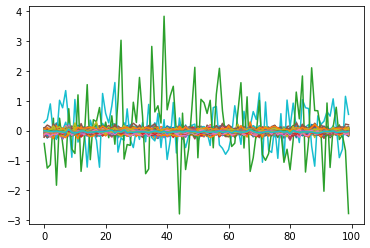

In [7]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])

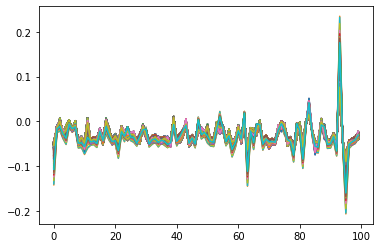

In [7]:
for _ in range(10):
    ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
    for i in range(len(ps_fake)):
        plt.plot(list(range(100)),ps_fake[i])

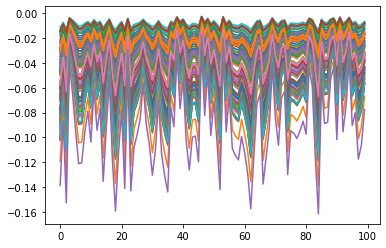

In [8]:
ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
for i in range(len(ps_fake)):
    plt.plot(list(range(100)),ps_fake[i])

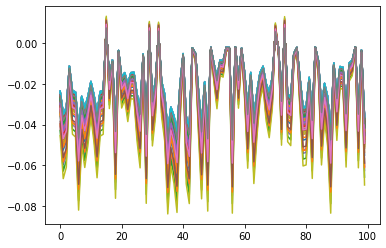

In [13]:
ps_fake = generator(mean=0, std=1).reshape(batch_size,-1).detach().cpu()
for i in range(len(ps_fake)):
    plt.plot(list(range(100)),ps_fake[i]/-1e10)

In [7]:
ps_fake

tensor([[2.9931e+08, 4.3878e+08, 4.0206e+08,  ..., 4.0381e+08, 4.1310e+07,
         4.5880e+08],
        [4.2777e+08, 6.2704e+08, 5.7457e+08,  ..., 5.7697e+08, 5.8824e+07,
         6.5672e+08],
        [3.0092e+08, 4.4114e+08, 4.0422e+08,  ..., 4.0597e+08, 4.1520e+07,
         4.6132e+08],
        ...,
        [3.0171e+08, 4.4229e+08, 4.0528e+08,  ..., 4.0703e+08, 4.1624e+07,
         4.6256e+08],
        [2.8306e+08, 4.1499e+08, 3.8025e+08,  ..., 3.8196e+08, 3.9181e+07,
         4.3336e+08],
        [5.1677e+08, 7.5750e+08, 6.9412e+08,  ..., 6.9701e+08, 7.1061e+07,
         7.9336e+08]])

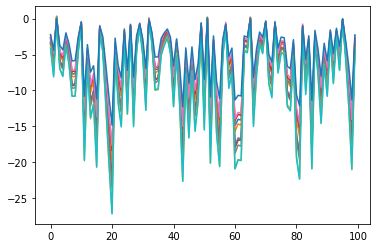

In [20]:
for i in range(len(ps_fake)):
    plt.plot(list(range(100)),ps_fake[i].cpu())
    if i == 10:
        break

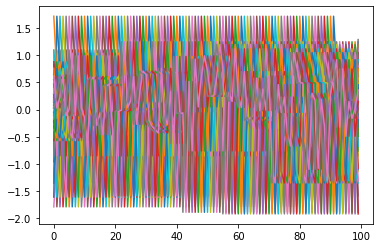

In [47]:
for data in dataloader:
    ps_real = data[0].permute(0,2,1).squeeze(-1)
    for i in range(len(ps_real)):
        plt.plot(list(range(100)),ps_real[i].cpu())

    break

In [43]:
ts_real = trade_strategy.get_strategy_PnL(ps_real).cpu()#,torch.ones_like(ps_real))
ts_fake = trade_strategy.get_strategy_PnL(ps_fake).cpu()#,torch.ones_like(ps_fake))

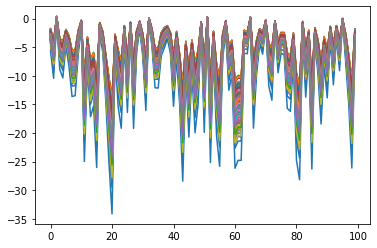

In [46]:
for i in range(len(ps_real)):
#     plt.plot(list(range(100)),ts_real[i])
    plt.plot(list(range(100)),ts_fake[i])

In [ ]:
generator.eval()
noise = torch.randn(80,3,127).to(device)
y = generator(noise).cpu().detach().squeeze();

y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()
len(y)

## Results and visualizing stylized facts

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:30], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

In [ ]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])


In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(log_returns, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')

In [56]:
t = torch.tensor([1.,5.,3.],requires_grad = True)
b = torch.tensor([1.,2.,3.]).reshape(-1,1)
result = torch.matmul(torch.sort(t)[0],b)
result.backward()
t.grad

tensor([1., 3., 2.])

In [57]:
result.backward()
t.grad

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
result = torch.matmul(torch.sort(t)[0],b)
result.backward()
t.grad

In [8]:
t = torch.tensor([1.,5.,3.],requires_grad = True).cuda()

In [12]:
(t>t).long()

tensor([0, 0, 0], device='cuda:0')

In [53]:
t.detach().cpu().cuda().cuda()

tensor([1., 5., 3.], device='cuda:0')

In [11]:
tanh = nn.Tanh()

In [13]:
tanh(t)

tensor([0.7616, 0.9999, 0.9951], device='cuda:0', grad_fn=<TanhBackward0>)